# Building an ML system for predicting NZ Earthquakes

Get data from [GeoNet](https://www.geonet.org.nz/), make examples for ML system, build the ML system

## Getting Data

Download as much seismograph timeseries data as possible from GeoNet. ~~Ideally this will be from all/multiple seismographs, over a span of years (?). ~~

~~If this seems like way too much data then use the database of quakes to download all the days which had quakes (for positive examples) and also download a similar amount of data for other non-quake days (for negative examples).~~

Initially I will take quake data an hour before and an hour after the quake, quakes will be the last approx 10,000 quakes above magnitude 4. 

Non quake data will be found by taking a random 2 hour slice and checking that there was no quake that day (?? maybe just no quake inside it). 


I think the specific quake days is probably better, and if we have the time if the quake it will make selecting for the training examples easier. 

## Making examples for ML

Ok. so this is maybe the actually hard/smart bit. 

First I am keen to try a CNN approach. For this approach, generate spectrograms of siesograph data for a period of time before the quake. For example a 5 minute section which occurs 2 minutes before the quake, probably vary that 2 mins around a bit. 

As a sanity check could do literally an "Is there an earthquake happening?" machine, were you just feed it examples from **during the quake** and see if it can tell if there's a quake. 

For these 2D (M x N) spectrograms, then make a 3D (M x N x S) 'image' where S is the number of seismographs. 

## ML system

Now that we have the (M x N x S) 'images' then we can hopefully use a modified CNN to train our system. 



# Getting Data

Following https://github.com/GeoNet/data-tutorials/blob/master/Seismic_Data/Python/GeoNet_FDSN_demo_clients.ipynb

https://github.com/GeoNet/data-tutorials/blob/master/Seismic_Data/Python/GeoNet_FDSN_demo_dataselect.ipynb

I have a list of all the quakes above magnetude 4 for the past 10 ish years, as well as a list of all currently operational broadband seismographs. The goal is to run through (randomly) the list of quakes, and for each quake download the seismograph data for 2 hours on either side. Save in a file for each quake, with each siesmograph as a different datafile. 

We will check that the start time is less than the quake time, which means that the station should be running then, if its not, append the quake id, quake time and station id and start time to the a list just to keep track of some things.  

In [1]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client as FDSN_Client
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import os
from progress.bar import Bar
from tqdm.notebook import tqdm
from multiprocessing import Pool
from glob import glob

In [6]:
#load list of quakes
quakelist=pd.read_csv('data/quakelist1.txt',sep="|") 
quakelist.columns = quakelist.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

#load stationlist
stationlist=pd.read_csv('data/station_h_data.txt',sep="|")
stationlist.columns = stationlist.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [7]:
quakelist

,eventid,time,latitude,longitude,depth/km,author,catalog,contributor,contributorid,magtype,magnitude,magauthor,eventlocationname
0,2016p868245,2016-11-17T06:01:10,-42.222,173.586,15.0,GNS,GNS,GNS,2016p868245,M,4.3,GNS,20 km north of Kaikoura
1,2016p890934,2016-11-25T15:25:47,-18.902,-175.432,183.0,GNS,GNS,GNS,2016p890934,M,4.1,GNS,2080 km north-east of Cape Reinga
2,2018p951534,2018-12-19T01:37:40,-36.140,-101.700,10.0,GNS,GNS,GNS,2018p951534,mB,6.1,GNS,6860 km south-east of Tolaga Bay
3,2016p971842,2016-12-25T13:57:38,-34.571,-178.637,33.0,GNS,GNS,GNS,2016p971842,Mw(mB),4.0,GNS,430 km north-east of Te Araroa
4,2016p934797,2016-12-11T20:57:54,-24.232,-179.541,467.0,GNS,GNS,GNS,2016p934797,M,5.1,GNS,1355 km north-east of Cape Reinga
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9235,2013p198520,2013-03-15T10:50:32,-31.618,-178.682,134.2,GNS,GNS,GNS,2013p198520,M,4.1,GNS,715 km north-east of Te Araroa
9236,2013p208507,2013-03-19T03:31:30,-32.756,-179.552,12.0,GNS,GNS,GNS,2013p208507,M,5.2,GNS,570 km north of Te Araroa
9237,2013p212396,2013-03-20T14:02:28,-22.065,-179.490,581.0,GNS,GNS,GNS,2013p212396,M,4.6,GNS,1565 km north-east of Cape Reinga
9238,2013p215643,2013-03-21T18:54:01,-31.687,-179.487,261.0,GNS,GNS,GNS,2013p215643,M,4.4,GNS,685 km north of Te Araroa


In [8]:
stationlist

,#network,station,latitude,longitude,elevation,sitename,starttime,endtime
0,NZ,APZ,-46.831806,167.988825,601.0,The Paps,2006-05-07T00:00:00,NaN
1,NZ,BFZ,-40.679647,176.246245,283.0,Birch Farm,1996-04-03T00:00:00,NaN
2,NZ,BHW,-41.408231,174.871115,101.0,Baring Head,1975-11-27T00:00:00,NaN
3,NZ,BKZ,-39.165666,176.492544,706.0,Black Stump Farm,2004-02-11T00:00:00,NaN
4,NZ,COVZ,-39.199914,175.542402,1133.0,Chateau Observatory,1998-03-25T00:00:00,NaN
...,...,...,...,...,...,...,...,...
69,NZ,WHZ,-45.892428,167.947031,345.0,Wether Hill Road,1993-03-22T00:00:00,NaN
70,NZ,WIZ,-37.524511,177.189302,40.0,White Island,1976-12-12T00:00:00,NaN
71,NZ,WKZ,-44.827021,169.017562,558.0,Wanaka,2004-06-03T00:00:00,NaN
72,NZ,WSRZ,-37.518110,177.177805,292.4,White Island Summit,2013-04-08T00:00:00,NaN


In [13]:
np.random.seed(42)
rand_inds=np.array(range(len(quakelist)))
np.random.shuffle(rand_inds)

In [14]:
rand_inds[0]

4608

In [7]:
40*100/60

66.66666666666667

In [8]:
rand_inds1=rand_inds[0:3]

In [9]:
client = FDSN_Client("GEONET")
client_nrt = FDSN_Client("https://service-nrt.geonet.org.nz")

In [10]:
aa=np.random.randn(90)
file_name='test_aa.pkl'
pkl_file=open(file_name,'wb')
pickle.dump('aa',pkl_file)

In [11]:
quake_before_station_columns=['quakeid','quaketime','stationid','stationstart']
quake_before_station=pd.DataFrame(columns=quake_before_station_columns)

savefail_columns=['quakeid','quaketime','stationid','stationstart']
savefail=pd.DataFrame(columns=savefail_columns)
# pd.DataFrame(quakelist['eventid'][quake_ind],quakelist['time'][quake_ind],
#                             stationlist['station'][station_ind],stationlist['starttime'][station_ind],columns=quake_before_station_columns)

# pd.DataFrame(quakelist['eventid'][quake_ind],quakelist['time'][quake_ind],
#                             stationlist['station'][station_ind],stationlist['starttime'][station_ind],columns=quake_before_station_columns)

In [12]:
# aa={"quakeid":quakelist['eventid'][1],
#                                           "quaketime":quakelist['time'][1],
#                                           "stationid":stationlist['station'][0],
#                                           "stationstart":stationlist['starttime'][0]}
# bb={"quakeid":quakelist['eventid'][1],
#                                           "quaketime":quakelist['time'][1],
#                                           "stationid":stationlist['station'][1],
#                                           "stationstart":stationlist['starttime'][1]}
# quake_before_station=quake_before_station.append(aa,ignore_index=True)
# quake_before_station=quake_before_station.append(bb,ignore_index=True)


In [13]:
quake_before_station

,quakeid,quaketime,stationid,stationstart


In [14]:
station_list1=['APZ', 'BFZ', 'BKZ', 'COVZ', 'CTZ', 'DCZ', 'DSZ', 'EAZ', 'FOZ',
       'FWVZ', 'GLKZ', 'GRZ', 'GVZ', 'HAZ', 'HIZ', 'INZ', 'JCZ', 'KHEZ',
       'KHZ', 'KNZ',  'LBZ', 'LTZ', 'MAVZ', 'MKAZ', 'MLZ', 'MQZ',
       'MRZ', 'MSZ', 'MWZ', 'MXZ', 'NNZ', 'ODZ', 'OPRZ', 'OPZ', 'OTVZ',
       'OUZ', 'OXZ', 'PUZ', 'PXZ', 'PYZ', 'QRZ', 'RATZ', 'RIZ', 'RPZ',
       'RTZ', 'SYZ', 'THZ', 'TLZ', 'TMVZ', 'TOZ', 'TRVZ', 'TSZ', 'TUZ',
       'URZ', 'VRZ', 'WAZ', 'WCZ', 'WEL', 'WHVZ', 'WHZ', 'WIZ', 'WKZ',
       'WSRZ', 'WVZ']
#have removed KUZ cos it looked bad

In [15]:
len(station_list1)

64

In [16]:
1+1

2

In [17]:
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')


In [18]:
stationlist['station'][0]

'APZ'

In [30]:
t_before=30*60
t_after=10*60

ii=0
data_dir='/media/peter/data/earthquakenz/data/waveforms/'

for quake_ind in rand_inds[0:3]:
    print('===== STARTING: '+ quakelist['time'][quake_ind]+', ' +str(ii)+'=====')
    
    t=UTCDateTime(quakelist['time'][quake_ind])
    if not os.path.exists(data_dir+quakelist['eventid'][quake_ind]):
        os.mkdir(data_dir+quakelist['eventid'][quake_ind])
    for station_ind in tqdm(range(len(stationlist))):
        file_name=data_dir+quakelist['eventid'][quake_ind]+'/'+stationlist['station'][station_ind]+'.pkl'
        if (stationlist['station'][station_ind] in station_list1):
            if stationlist['starttime'][station_ind]<t :
                try:
    #                 st= client.get_waveforms("NZ",stationlist['station'][station_ind],"*", "HHZ,HHN,HHE,HH1,HH2", t-t_before, t+t_after ,minimumlength=t_before,attach_response=True)
                    st= client.get_waveforms("NZ",stationlist['station'][station_ind] ,"*", "HH?", t-t_before, t+t_after,attach_response=True)

    #                 file_name=data_dir+quakelist['eventid'][quake_ind]+'/'+stationlist['station'][station_ind]+'.pkl'#/data/'+quakelist['eventid'][quake_ind]+'/' +stationlist['station'][station_ind]+'.pkl'
    #                 print(st)
    #                 print(file_name)
    #                 pkl_file=open(file_name,'wb')
    #                 pickle.dump(st,pkl_file)
                    with open(file_name,'wb') as f:
                        pickle.dump(st,f)
                except:
                    aa={"quakeid":quakelist['eventid'][quake_ind],
                                              "quaketime":quakelist['time'][quake_ind],
                                              "stationid":stationlist['station'][station_ind]
                                              ,"stationstart":stationlist['starttime'][station_ind]}
                    savefail=savefail.append(aa,ignore_index=True)

                    print('savefail:' + quakelist['eventid'][quake_ind]+'/'+stationlist['station'][station_ind])
                    pass
            else:
                aa={"quakeid":quakelist['eventid'][quake_ind],
                                          "quaketime":quakelist['time'][quake_ind],
                                          "stationid":stationlist['station'][station_ind]
                                          ,"stationstart":stationlist['starttime'][station_ind]}
                quake_before_station=quake_before_station.append(aa,ignore_index=True)

                print('quake before station:' + quakelist['eventid'][quake_ind]+'/'+stationlist['station'][station_ind])
    ii=ii+1
    with open(data_dir+'quake_before_station.pkl','wb') as f:
        pickle.dump(quake_before_station,f)
    with open(data_dir+'savefail.pkl','wb') as f:
        pickle.dump(savefail,f)
        #st = client.get_waveforms("NZ",stationlist['station'][station_ind] ,"*", "H??", t-3600, t+3600 ,attach_response=True)

===== STARTING: 2019-05-10T03:43:18, 0=====



===== STARTING: 2016-08-28T18:14:07, 1=====


savefail:2016p650710/VRZ

===== STARTING: 2019-04-05T07:26:53, 2=====


savefail:2019p254897/RATZ



In [300]:
def paralell_download(quake_ind):
    print(' STARTING: '+ quakelist['eventid'][quake_ind])
    
    t=UTCDateTime(quakelist['time'][quake_ind])
    if not os.path.exists(data_dir+quakelist['eventid'][quake_ind]):
        os.mkdir(data_dir+quakelist['eventid'][quake_ind])
    for station_ind in tqdm(range(len(stationlist)),leave=False, desc=quakelist['eventid'][quake_ind]):
        file_name=data_dir+quakelist['eventid'][quake_ind]+'/'+stationlist['station'][station_ind]+'.pkl'
        if (stationlist['station'][station_ind] in station_list1):
            if stationlist['starttime'][station_ind]<t :
                attempts=0
                while attempts <4:
                    try:
        #                 st= client.get_waveforms("NZ",stationlist['station'][station_ind],"*", "HHZ,HHN,HHE,HH1,HH2", t-t_before, t+t_after ,minimumlength=t_before,attach_response=True)
                        st= client.get_waveforms("NZ",stationlist['station'][station_ind] ,"*", "HH?", t-t_before, t+t_after,attach_response=True)

        #                 file_name=data_dir+quakelist['eventid'][quake_ind]+'/'+stationlist['station'][station_ind]+'.pkl'#/data/'+quakelist['eventid'][quake_ind]+'/' +stationlist['station'][station_ind]+'.pkl'
        #                 print(st)
        #                 print(file_name)
        #                 pkl_file=open(file_name,'wb')
        #                 pickle.dump(st,pkl_file)
                        with open(file_name,'wb') as f:
                            pickle.dump(st,f)
                        break
                    except:
                        attempts+=1
    #                     aa={"quakeid":quakelist['eventid'][quake_ind],
    #                                               "quaketime":quakelist['time'][quake_ind],
    #                                               "stationid":stationlist['station'][station_ind]
    #                                               ,"stationstart":stationlist['starttime'][station_ind]}
    #                     savefail=savefail.append(aa,ignore_index=True)
                if not attempts<4: 
                        savefail=open(data_dir+'savefail.txt','a')
                        savefail.write(quakelist['eventid'][quake_ind]+' '+stationlist['station'][station_ind])
                        savefail.write("\n")
                        savefail.close()
                        print('savefail:' + quakelist['eventid'][quake_ind]+'/'+stationlist['station'][station_ind])
#                         pass
            else:
#                 aa={"quakeid":quakelist['eventid'][quake_ind],
#                                           "quaketime":quakelist['time'][quake_ind],
#                                           "stationid":stationlist['station'][station_ind]
#                                           ,"stationstart":stationlist['starttime'][station_ind]}
#                 quake_before_station=quake_before_station.append(aa,ignore_index=True)
                quake_before_station_file=open(data_dir+'quake_before_station.txt','a')
                quake_before_station_file.write(quakelist['eventid'][quake_ind]+' '+stationlist['station'][station_ind])
                quake_before_station_file.write("\n")
                quake_before_station_file.close()
                print('quake before station:' + quakelist['eventid'][quake_ind]+'/'+stationlist['station'][station_ind])
#     with open(data_dir+'quake_before_station.pkl','wb') as f:
#         pickle.dump(quake_before_station,f)
#     with open(data_dir+'savefail.pkl','wb') as f:
#         pickle.dump(savefail,f)
        #st = client.get_waveforms("NZ",stationlist['station'][station_ind] ,"*", "H??", t-3600, t+3600 ,attach_response=True)

In [76]:
pool = Pool(processes=10) # how much parallelism?
pool.map(paralell_download, rand_inds[0:100])

 STARTING: 2016p605803
 STARTING: 2014p934733
 STARTING: 2017p087353
 STARTING: 2019p538485
 STARTING: 2014p203255
 STARTING: 2019p349067
 STARTING: 2020p042145
 STARTING: 2018p152896
 STARTING: 2018p706057
 STARTING: 2015p039141


savefail:2016p605803/BKZ
savefail:2014p203255/COVZ
savefail:2014p203255/DCZ
savefail:2015p039141/DCZ
savefail:2018p706057/DCZ
savefail:2019p538485/GLKZ
savefail:2015p039141/MKAZ
savefail:2018p152896/OPRZ
savefail:2019p538485/OTVZ
savefail:2018p152896/QRZ
savefail:2019p538485/RIZ
savefail:2014p934733/TRVZ
 STARTING: 2013p932430


 STARTING: 2017p931707


 STARTING: 2016p650710


 STARTING: 2019p085965


savefail:2013p932430/COVZ
 STARTING: 2019p966434


 STARTING: 2013p089800


savefail:2017p931707/DCZ
 STARTING: 2015p588076


 STARTING: 2019p177534


 STARTING: 2016p858841


 STARTING: 2019p475307


savefail:2015p588076/DCZ
savefail:2013p089800/GVZ
savefail:2015p588076/MKAZ
savefail:2016p650710/VRZ
quake before station:2013p089800/TMVZ
savefail:2013p089800/TSZ
 STARTING: 2019p254897


 STARTING: 2017p928748


 STARTING: 2013p963215


savefail:2017p928748/DCZ
savefail:2013p963215/BKZ
savefail:2013p963215/COVZ
quake before station:2013p089800/WSRZ
 STARTING: 2015p867180


savefail:2013p932430/WAZ
 STARTING: 2014p232716


 STARTING: 2012p864682


savefail:2014p232716/COVZ
 STARTING: 2017p879247


 STARTING: 2016p661415


 STARTING: 2013p718195


savefail:2013p718195/COVZ
quake before station:2012p864682/GVZ
 STARTING: 2014p638289


savefail:2012p864682/MRZ
savefail:2019p254897/RATZ
savefail:2015p867180/MKAZ
 STARTING: 2019p140988


quake before station:2012p864682/TMVZ
 STARTING: 2014p226537


 STARTING: 2014p817550


savefail:2014p226537/COVZ
 STARTING: 2019p562914


savefail:2014p817550/EAZ
savefail:2016p661415/VRZ
quake before station:2012p864682/WSRZ
 STARTING: 2017p615484


 STARTING: 2019p890414


 STARTING: 2014p466765


 STARTING: 2013p744643


 STARTING: 2018p166932


savefail:2013p744643/COVZ
 STARTING: 2017p012002


savefail:2014p466765/MSZ
savefail:2018p166932/OPRZ
savefail:2018p166932/QRZ
 STARTING: 2015p324370


 STARTING: 2018p471984


 STARTING: 2019p665636


 STARTING: 2019p660829


 STARTING: 2013p544418


 STARTING: 2019p726214


 STARTING: 2013p951878


 STARTING: 2012p895818


 STARTING: 2015p610603


savefail:2013p544418/DSZ
savefail:2013p951878/COVZ
savefail:2015p610603/CTZ
savefail:2015p610603/DCZ
savefail:2015p324370/MKAZ
savefail:2015p610603/GLKZ
 STARTING: 2015p905294


quake before station:2012p895818/GVZ
savefail:2019p665636/MWZ
savefail:2019p660829/MWZ
savefail:2015p610603/MKAZ
savefail:2018p471984/RPZ
savefail:2013p544418/PYZ
savefail:2015p905294/MKAZ
quake before station:2012p895818/TMVZ
 STARTING: 2019p685091


 STARTING: 2017p295787


 STARTING: 2014p282757


 STARTING: 2019p180936


savefail:2014p282757/COVZ
quake before station:2012p895818/WSRZ
savefail:2014p282757/DCZ
 STARTING: 2018p429737


 STARTING: 2013p278252


 STARTING: 2013p498572


 STARTING: 2020p212677


savefail:2018p429737/BKZ
 STARTING: 2019p795087


savefail:2017p295787/KHZ
savefail:2017p295787/KNZ
savefail:2020p212677/GLKZ
 STARTING: 2019p435645


savefail:2017p295787/MKAZ
savefail:2014p282757/MKAZ
savefail:2019p685091/MWZ
savefail:2013p278252/SYZ
quake before station:2013p278252/TMVZ
savefail:2019p685091/VRZ
savefail:2013p498572/TSZ
 STARTING: 2019p942200


 STARTING: 2012p986878


 STARTING: 2016p859060


 STARTING: 2019p580803


 STARTING: 2016p858323


 STARTING: 2016p858517


savefail:2012p986878/GVZ
 STARTING: 2019p503442


 STARTING: 2019p942041


 STARTING: 2017p377425


 STARTING: 2016p858347


savefail:2017p377425/GRZ
savefail:2017p377425/MKAZ
quake before station:2012p986878/TMVZ
quake before station:2012p986878/WSRZ
 STARTING: 2018p862602


 STARTING: 2014p819117


 STARTING: 2019p495282


 STARTING: 2019p556106


 STARTING: 2019p581989


savefail:2018p862602/DCZ
savefail:2014p819117/DCZ
 STARTING: 2019p174851


savefail:2014p819117/EAZ
 STARTING: 2020p008781


 STARTING: 2014p354108


savefail:2014p354108/COVZ
savefail:2017p377425/WSRZ
 STARTING: 2019p070484


savefail:2019p070484/APZ
 STARTING: 2020p000088


savefail:2019p495282/MKAZ
savefail:2020p008781/JCZ
savefail:2020p000088/JCZ
savefail:2014p354108/OPRZ
 STARTING: 2014p525115


 STARTING: 2017p731981


 STARTING: 2015p389806


 STARTING: 2013p809096


 STARTING: 2019p844246


 STARTING: 2020p095982


savefail:2013p809096/COVZ
savefail:2013p809096/FOZ
 STARTING: 2014p627749


 STARTING: 2017p253429


savefail:2014p525115/MKAZ
 STARTING: 2013p148302


 STARTING: 2013p416378


savefail:2015p389806/MKAZ
savefail:2015p389806/PYZ
savefail:2013p809096/PYZ
savefail:2017p253429/MKAZ
savefail:2014p525115/TMVZ
savefail:2013p416378/MAVZ
 STARTING: 2016p111142


savefail:2013p416378/PYZ
 STARTING: 2019p158799


 STARTING: 2015p108231


 STARTING: 2017p394437


quake before station:2013p148302/TMVZ
savefail:2015p108231/FWVZ
savefail:2014p627749/WHVZ
savefail:2017p394437/GRZ
savefail:2016p111142/MKAZ
quake before station:2013p148302/WSRZ
savefail:2015p108231/TRVZ
 STARTING: 2014p001815


savefail:2014p001815/BKZ
savefail:2014p001815/COVZ
 STARTING: 2017p626052


 STARTING: 2016p883338


 STARTING: 2018p093418


 STARTING: 2015p214038


 STARTING: 2016p872630


savefail:2015p214038/DCZ
savefail:2015p214038/MKAZ
savefail:2016p872630/MAVZ


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [78]:
np.random.rand(4)

array([ 0.74539774,  0.37895591,  0.30276761,  0.45934601])

In [26]:
#test with start times randomly distributed between 12 and 18 mins before the offical time
t_before_rand=(15+np.random.rand(len(quakelist))*6-3)*60
data_dir='/media/peter/data/earthquakenz/data/waveforms2/'
station_list1=['APZ', 'BFZ', 'BKZ', 'CTZ',  'DSZ', 'EAZ', 'FOZ',
       'FWVZ', 'GLKZ', 'GRZ', 'GVZ', 'HAZ', 'HIZ', 'INZ', 'JCZ', 'KHEZ',
       'KHZ', 'KNZ',  'LBZ', 'LTZ', 'MLZ', 'MQZ',
       'MRZ', 'MSZ', 'MWZ', 'MXZ', 'NNZ', 'ODZ', 'OPRZ', 'OPZ', 'OTVZ',
       'OUZ', 'OXZ', 'PUZ', 'PXZ', 'PYZ', 'QRZ', 'RATZ', 'RIZ', 
       'RTZ', 'SYZ', 'THZ', 'TLZ', 'TMVZ', 'TOZ', 'TRVZ', 'TSZ', 'TUZ',
        'VRZ', 'WAZ', 'WCZ', 'WEL', 'WHVZ', 'WHZ', 'WIZ', 'WKZ',
       'WSRZ', 'WVZ']

def paralell_download_rand(quake_ind):
    print(' STARTING: '+ quakelist['eventid'][quake_ind])
    
    t=UTCDateTime(quakelist['time'][quake_ind])
    if not os.path.exists(data_dir+quakelist['eventid'][quake_ind]):
        os.mkdir(data_dir+quakelist['eventid'][quake_ind])
    for station_ind in tqdm(range(len(stationlist)),leave=False, desc=quakelist['eventid'][quake_ind]):
        file_name=data_dir+quakelist['eventid'][quake_ind]+'/'+stationlist['station'][station_ind]+'.pkl'
        if (stationlist['station'][station_ind] in station_list1):
            if stationlist['starttime'][station_ind]<t :
                attempts=0
                while attempts <4:
                    try:
        #                 st= client.get_waveforms("NZ",stationlist['station'][station_ind],"*", "HHZ,HHN,HHE,HH1,HH2", t-t_before, t+t_after ,minimumlength=t_before,attach_response=True)
                        st= client.get_waveforms("NZ",stationlist['station'][station_ind] ,"*", "HH?", t-t_before_rand[quake_ind]-10, t-t_before_rand[quake_ind]+5*60+10,attach_response=True)

        #                 file_name=data_dir+quakelist['eventid'][quake_ind]+'/'+stationlist['station'][station_ind]+'.pkl'#/data/'+quakelist['eventid'][quake_ind]+'/' +stationlist['station'][station_ind]+'.pkl'
        #                 print(st)
        #                 print(file_name)
        #                 pkl_file=open(file_name,'wb')
        #                 pickle.dump(st,pkl_file)
                        with open(file_name,'wb') as f:
                            pickle.dump(st,f)
                        break
                    except:
                        attempts+=1
    #                     aa={"quakeid":quakelist['eventid'][quake_ind],
    #                                               "quaketime":quakelist['time'][quake_ind],
    #                                               "stationid":stationlist['station'][station_ind]
    #                                               ,"stationstart":stationlist['starttime'][station_ind]}
    #                     savefail=savefail.append(aa,ignore_index=True)
                if not attempts<4: 
                        savefail=open(data_dir+'savefail.txt','a')
                        savefail.write(quakelist['eventid'][quake_ind]+' '+stationlist['station'][station_ind])
                        savefail.write("\n")
                        savefail.close()
                        print('savefail:' + quakelist['eventid'][quake_ind]+'/'+stationlist['station'][station_ind])
#                         pass
            else:
#                 aa={"quakeid":quakelist['eventid'][quake_ind],
#                                           "quaketime":quakelist['time'][quake_ind],
#                                           "stationid":stationlist['station'][station_ind]
#                                           ,"stationstart":stationlist['starttime'][station_ind]}
#                 quake_before_station=quake_before_station.append(aa,ignore_index=True)
                quake_before_station_file=open(data_dir+'quake_before_station.txt','a')
                quake_before_station_file.write(quakelist['eventid'][quake_ind]+' '+stationlist['station'][station_ind])
                quake_before_station_file.write("\n")
                quake_before_station_file.close()
                print('quake before station:' + quakelist['eventid'][quake_ind]+'/'+stationlist['station'][station_ind])
#     with open(data_dir+'quake_before_station.pkl','wb') as f:
#         pickle.dump(quake_before_station,f)
#     with open(data_dir+'savefail.pkl','wb') as f:
#         pickle.dump(savefail,f)
        #st = client.get_waveforms("NZ",stationlist['station'][station_ind] ,"*", "H??", t-3600, t+3600 ,attach_response=True)

In [27]:
pool = Pool(processes=10) # how much parallelism?
pool.map(paralell_download_rand, rand_inds[0:2000])

 STARTING: 2016p858356
 STARTING: 2019p168943
 STARTING: 2016p858184
 STARTING: 2013p542721
 STARTING: 2014p915309
 STARTING: 2017p932437
 STARTING: 2019p795087
 STARTING: 2012p973573
 STARTING: 2017p480098
 STARTING: 2019p349067


KeyboardInterrupt: 

savefail:2013p542721/DSZ
savefail:2012p973573/GVZ
savefail:2013p542721/PYZ
quake before station:2012p973573/TMVZ
savefail:2014p915309/TRVZ
 STARTING: 2016p858368


quake before station:2012p973573/WSRZ
 STARTING: 2019p193421


 STARTING: 2014p869447


 STARTING: 2019p207336


 STARTING: 2016p650710
 STARTING: 2014p712058


 STARTING: 2019p969656


savefail:2014p712058/BKZ
savefail:2014p712058/DSZ
savefail:2014p712058/FOZ
 STARTING: 2013p744643


 STARTING: 2020p122292


 STARTING: 2015p246766


savefail:2014p712058/HAZ
savefail:2014p712058/HIZ
savefail:2014p712058/KHZ
savefail:2014p712058/KNZ
savefail:2014p712058/LTZ
savefail:2014p712058/MRZ
savefail:2014p712058/MWZ
savefail:2014p712058/ODZ
savefail:2014p712058/OUZ
savefail:2014p712058/PUZ
savefail:2014p712058/PYZ
savefail:2014p712058/QRZ
savefail:2019p207336/RATZ
savefail:2014p712058/TLZ
savefail:2014p712058/TRVZ
savefail:2014p712058/VRZ
savefail:2014p712058/WCZ
savefail:2014p712058/WHVZ
savefail:2014p712058/WKZ
savefail:2016p650710/VRZ
 STARTING: 2019p101132


 STARTING: 2019p736679


 STARTING: 2019p158279


 STARTING: 2019p254897


 STARTING: 2014p347148
 STARTING: 2016p137560


savefail:2019p969656/WIZ
 STARTING: 2017p340634


 STARTING: 2012p895818


 STARTING: 2017p662580


 STARTING: 2019p026517


quake before station:2012p895818/GVZ
savefail:2014p347148/OPRZ
savefail:2019p254897/RATZ
savefail:2019p026517/MWZ
 STARTING: 2017p341158


quake before station:2012p895818/TMVZ
 STARTING: 2019p738432


 STARTING: 2014p631123


 STARTING: 2015p675726


 STARTING: 2017p090786


 STARTING: 2017p575702


 STARTING: 2016p605803


quake before station:2012p895818/WSRZ
savefail:2016p605803/BKZ
 STARTING: 2018p429737


savefail:2018p429737/BKZ
savefail:2015p675726/GRZ
 STARTING: 2020p179031


 STARTING: 2015p674167


savefail:2015p674167/GRZ
savefail:2017p575702/RTZ
 STARTING: 2019p067815


savefail:2019p067815/APZ
savefail:2014p631123/WHVZ
 STARTING: 2012p873490


 STARTING: 2013p400082


 STARTING: 2017p792376


 STARTING: 2017p931707


 STARTING: 2014p252676


 STARTING: 2015p674079


 STARTING: 2018p166932


quake before station:2012p873490/GVZ
 STARTING: 2014p711461


savefail:2014p711461/BKZ
savefail:2015p674079/GRZ
savefail:2014p711461/DSZ
savefail:2014p711461/FOZ
 STARTING: 2014p140351


savefail:2014p711461/HAZ
savefail:2014p711461/HIZ
savefail:2014p140351/CTZ
savefail:2014p711461/KHZ
savefail:2014p711461/KNZ
savefail:2014p711461/LTZ
savefail:2014p711461/MQZ
savefail:2014p711461/MRZ
savefail:2014p711461/MWZ
savefail:2014p711461/MXZ
savefail:2014p711461/ODZ
savefail:2013p400082/PYZ
savefail:2014p711461/OUZ
savefail:2018p166932/OPRZ
savefail:2014p711461/PUZ
savefail:2014p711461/PYZ
savefail:2014p711461/QRZ
quake before station:2012p873490/TMVZ
savefail:2018p166932/QRZ
savefail:2014p711461/TLZ
savefail:2014p711461/TRVZ
 STARTING: 2019p679323


savefail:2014p711461/VRZ
quake before station:2012p873490/WSRZ
savefail:2014p711461/WCZ
 STARTING: 2019p028887


savefail:2014p711461/WHVZ
 STARTING: 2013p974168


savefail:2013p974168/BKZ
savefail:2014p711461/WKZ
 STARTING: 2016p085927


 STARTING: 2013p593087


 STARTING: 2017p928748


 STARTING: 2014p298783


 STARTING: 2013p097443


 STARTING: 2013p951878


savefail:2013p097443/GVZ
savefail:2019p679323/MWZ
 STARTING: 2018p712800


savefail:2019p028887/MWZ
savefail:2013p593087/PYZ
quake before station:2013p097443/TMVZ
savefail:2018p712800/OUZ
 STARTING: 2020p139664


 STARTING: 2018p919719


 STARTING: 2013p214133


 STARTING: 2016p858905


 STARTING: 2013p090836


quake before station:2013p097443/WSRZ
 STARTING: 2018p155531


savefail:2018p919719/FOZ
 STARTING: 2017p087353


 STARTING: 2020p142122


savefail:2020p139664/GLKZ
 STARTING: 2013p278252


savefail:2013p090836/GVZ
 STARTING: 2016p664429


savefail:2018p919719/QRZ
savefail:2018p155531/OPRZ
quake before station:2013p214133/TMVZ
savefail:2018p155531/QRZ
quake before station:2013p090836/TMVZ
savefail:2013p090836/TSZ
quake before station:2013p214133/WSRZ
savefail:2013p278252/SYZ
 STARTING: 2016p862973


quake before station:2013p278252/TMVZ
 STARTING: 2018p130600


quake before station:2013p090836/WSRZ
 STARTING: 2019p419869


 STARTING: 2020p218892


 STARTING: 2019p175010


 STARTING: 2019p571094


 STARTING: 2012p963057


 STARTING: 2019p085965


 STARTING: 2017p012002


savefail:2016p664429/VRZ
savefail:2012p963057/GVZ
 STARTING: 2018p726071


savefail:2018p130600/OPRZ
quake before station:2012p963057/TMVZ
 STARTING: 2020p066075


 STARTING: 2013p658515


savefail:2013p658515/BFZ
quake before station:2012p963057/WSRZ
 STARTING: 2019p461968


 STARTING: 2013p546702


 STARTING: 2013p963215


 STARTING: 2020p131320


 STARTING: 2015p905294


 STARTING: 2014p471355


savefail:2013p963215/BKZ
 STARTING: 2016p952114


 STARTING: 2014p258480


savefail:2013p658515/OUZ
savefail:2014p471355/MSZ
savefail:2013p546702/PYZ
savefail:2014p471355/TOZ
 STARTING: 2016p119218


 STARTING: 2015p556746


savefail:2015p556746/CTZ
 STARTING: 2013p222555


 STARTING: 2015p154355


savefail:2014p471355/WIZ
 STARTING: 2014p203255


 STARTING: 2019p435645


 STARTING: 2013p155974


 STARTING: 2014p132118


 STARTING: 2014p708931


savefail:2014p132118/CTZ
savefail:2013p222555/MLZ
 STARTING: 2019p661006


savefail:2013p222555/MSZ
savefail:2014p203255/MSZ
savefail:2014p708931/PYZ
savefail:2016p119218/TSZ
quake before station:2013p222555/TMVZ
savefail:2014p708931/TRVZ
quake before station:2013p155974/TMVZ
savefail:2019p661006/MWZ
 STARTING: 2018p398183


savefail:2014p708931/WHVZ
 STARTING: 2013p546148


quake before station:2013p222555/WSRZ
 STARTING: 2018p681818


 STARTING: 2019p043674


savefail:2019p043674/APZ
 STARTING: 2013p219457


quake before station:2013p155974/WSRZ
 STARTING: 2015p609629


savefail:2013p546148/GLKZ
 STARTING: 2013p932430


savefail:2015p609629/CTZ
 STARTING: 2013p755159


 STARTING: 2019p942200


savefail:2015p609629/GLKZ
savefail:2013p219457/MLZ
 STARTING: 2018p106732


savefail:2013p546148/PYZ
quake before station:2013p219457/TMVZ
 STARTING: 2012p868191


savefail:2013p932430/WAZ
quake before station:2013p219457/WSRZ
 STARTING: 2014p405625


savefail:2018p106732/OPRZ
 STARTING: 2016p858108


 STARTING: 2017p795065


quake before station:2012p868191/GVZ
 STARTING: 2019p224882


 STARTING: 2013p718195


 STARTING: 2015p694041


 STARTING: 2013p101517


savefail:2012p868191/MRZ
 STARTING: 2014p819117


savefail:2014p819117/EAZ
 STARTING: 2014p124655


savefail:2014p124655/CTZ
quake before station:2012p868191/TMVZ
savefail:2019p224882/RATZ
quake before station:2012p868191/WSRZ
 STARTING: 2015p765388


quake before station:2013p101517/TMVZ
savefail:2013p101517/TSZ
 STARTING: 2019p323787


 STARTING: 2020p133555


 STARTING: 2019p725811


quake before station:2013p101517/WSRZ
 STARTING: 2018p899032


 STARTING: 2019p538485


 STARTING: 2019p457264


 STARTING: 2019p708374


savefail:2018p899032/FOZ
savefail:2019p538485/GLKZ
savefail:2015p765388/OPRZ
 STARTING: 2014p525115


 STARTING: 2017p433631


savefail:2018p899032/OPRZ
savefail:2017p433631/FWVZ
savefail:2019p538485/OTVZ
savefail:2019p538485/RIZ
 STARTING: 2015p234611


 STARTING: 2013p130961


 STARTING: 2014p474492


 STARTING: 2018p903363


 STARTING: 2016p858841
 STARTING: 2017p151331


savefail:2014p525115/TMVZ
 STARTING: 2020p137292


 STARTING: 2018p622561


savefail:2018p903363/FOZ
 STARTING: 2012p986878


 STARTING: 2012p978941


savefail:2014p474492/MSZ
savefail:2018p903363/OPRZ
savefail:2012p986878/GVZ
savefail:2012p978941/GVZ
quake before station:2013p130961/TMVZ
savefail:2014p474492/TOZ
 STARTING: 2016p176102


quake before station:2013p130961/WSRZ
 STARTING: 2015p552379


savefail:2014p474492/WIZ
 STARTING: 2014p525112


 STARTING: 2019p478263


 STARTING: 2014p867862


quake before station:2012p978941/TMVZ
quake before station:2012p986878/TMVZ
 STARTING: 2014p638289


 STARTING: 2016p417841


 STARTING: 2018p485716


savefail:2018p485716/APZ
quake before station:2012p978941/WSRZ
quake before station:2012p986878/WSRZ
 STARTING: 2016p871629


 STARTING: 2018p862602


savefail:2016p417841/OPRZ
savefail:2014p525112/TMVZ
savefail:2016p417841/PYZ
 STARTING: 2016p028393


 STARTING: 2019p008544


savefail:2014p867862/TRVZ
 STARTING: 2013p436608


 STARTING: 2014p934733


 STARTING: 2019p622708


 STARTING: 2014p472175


 STARTING: 2014p001738


savefail:2014p001738/BKZ
 STARTING: 2016p880764


savefail:2019p008544/MWZ
 STARTING: 2017p731981


 STARTING: 2016p661393


savefail:2014p472175/MSZ
savefail:2016p880764/KHZ
savefail:2019p622708/MWZ
savefail:2016p028393/TOZ
savefail:2013p436608/PYZ
 STARTING: 2016p678852


savefail:2014p472175/TOZ
savefail:2014p934733/TRVZ
 STARTING: 2015p130272


savefail:2014p472175/WIZ
 STARTING: 2017p478411


savefail:2015p130272/FWVZ
 STARTING: 2013p292905


 STARTING: 2019p966434


 STARTING: 2018p188044


 STARTING: 2017p145169


 STARTING: 2019p060263


savefail:2019p060263/APZ
savefail:2016p661393/VRZ
savefail:2018p188044/KNZ
 STARTING: 2013p086368


 STARTING: 2016p859060


savefail:2017p478411/OPZ
savefail:2016p678852/RTZ
savefail:2015p130272/TOZ
savefail:2018p188044/OPRZ
savefail:2016p678852/VRZ
savefail:2018p188044/QRZ
quake before station:2013p292905/TMVZ
 STARTING: 2016p858555


 STARTING: 2013p285026


 STARTING: 2016p864401


 STARTING: 2019p508902


 STARTING: 2017p879247


 STARTING: 2019p322000


quake before station:2013p086368/TMVZ
 STARTING: 2020p258283


quake before station:2013p086368/WSRZ
 STARTING: 2015p107413


 STARTING: 2013p506791


 STARTING: 2019p581989


quake before station:2013p285026/TMVZ
 STARTING: 2017p429677


 STARTING: 2018p907778


savefail:2013p506791/OUZ
savefail:2018p907778/FOZ
 STARTING: 2018p730165


savefail:2013p506791/PYZ
 STARTING: 2018p706057


 STARTING: 2018p713962


 STARTING: 2013p294320


savefail:2015p107413/TRVZ
savefail:2013p506791/TSZ
 STARTING: 2012p984895


savefail:2018p907778/OPRZ
 STARTING: 2016p074729


 STARTING: 2013p546707


savefail:2012p984895/GVZ
 STARTING: 2013p809096


 STARTING: 2015p238781


savefail:2013p809096/FOZ
quake before station:2013p294320/TMVZ
 STARTING: 2012p866005


savefail:2013p546707/PYZ
quake before station:2012p984895/TMVZ
quake before station:2012p866005/GVZ
 STARTING: 2019p024880


 STARTING: 2017p539129


savefail:2013p809096/PYZ
 STARTING: 2019p365939


 STARTING: 2019p177534


savefail:2012p866005/MRZ
quake before station:2012p984895/WSRZ
 STARTING: 2015p158967


 STARTING: 2019p244692


 STARTING: 2015p768685


savefail:2019p024880/MWZ
 STARTING: 2019p580803


quake before station:2012p866005/TMVZ
 STARTING: 2019p125777


quake before station:2012p866005/WSRZ
 STARTING: 2013p629164


savefail:2013p629164/BFZ
 STARTING: 2019p543512


savefail:2019p244692/RATZ
 STARTING: 2019p708724


 STARTING: 2018p403552


savefail:2019p543512/GLKZ
 STARTING: 2016p661415


 STARTING: 2017p410372


savefail:2019p543512/KHEZ
savefail:2013p629164/PYZ
 STARTING: 2016p858145


 STARTING: 2016p718349


savefail:2019p543512/OTVZ
 STARTING: 2017p151264


 STARTING: 2019p174851


savefail:2019p543512/RIZ
 STARTING: 2016p279896


 STARTING: 2018p543252


savefail:2016p661415/VRZ
 STARTING: 2016p638606


 STARTING: 2015p817754


 STARTING: 2018p152896


 STARTING: 2019p966132


savefail:2016p718349/VRZ
savefail:2018p543252/JCZ
 STARTING: 2013p014685


savefail:2016p279896/PYZ
 STARTING: 2019p969086


 STARTING: 2014p891954


savefail:2013p014685/GVZ
 STARTING: 2020p095982


savefail:2018p152896/OPRZ
 STARTING: 2015p797363


savefail:2018p152896/QRZ
quake before station:2013p014685/TMVZ
 STARTING: 2016p949882


 STARTING: 2019p233346


 STARTING: 2013p488901


 STARTING: 2013p089800


 STARTING: 2013p737697


quake before station:2013p014685/WSRZ
 STARTING: 2016p847224


savefail:2013p089800/GVZ
savefail:2019p969086/WIZ
 STARTING: 2016p174221


 STARTING: 2016p569201


 STARTING: 2016p858323


 STARTING: 2013p068473


savefail:2019p233346/RATZ
quake before station:2013p089800/TMVZ
savefail:2013p089800/TSZ
savefail:2013p068473/GVZ
quake before station:2013p089800/WSRZ
savefail:2016p569201/OPRZ
 STARTING: 2015p867180


 STARTING: 2015p158812


 STARTING: 2019p745144


 STARTING: 2019p959911


savefail:2013p737697/WSRZ
 STARTING: 2019p048502


savefail:2019p048502/APZ
 STARTING: 2015p294422


 STARTING: 2013p097577


quake before station:2013p068473/TMVZ
savefail:2013p097577/GVZ
 STARTING: 2019p556106


 STARTING: 2013p480298


quake before station:2013p068473/WSRZ
 STARTING: 2016p149222


savefail:2016p149222/GLKZ
savefail:2016p149222/KNZ
 STARTING: 2013p380975


quake before station:2013p097577/TMVZ
 STARTING: 2020p042145


savefail:2013p480298/OPRZ
quake before station:2013p097577/WSRZ
 STARTING: 2017p447679


 STARTING: 2015p511398


 STARTING: 2019p363838


 STARTING: 2016p661442


 STARTING: 2013p803751


savefail:2013p803751/FOZ
savefail:2013p380975/PYZ
 STARTING: 2013p022527


 STARTING: 2015p389806


 STARTING: 2017p207675


savefail:2013p022527/GVZ
savefail:2015p511398/PYZ
savefail:2013p803751/PYZ
 STARTING: 2015p155616


savefail:2013p022527/MLZ
savefail:2013p022527/MSZ
savefail:2016p661442/VRZ
savefail:2017p207675/OPRZ
 STARTING: 2019p475307


 STARTING: 2013p712374


 STARTING: 2013p728770


 STARTING: 2015p809244


savefail:2015p389806/PYZ
savefail:2013p022527/SYZ
quake before station:2013p022527/TMVZ
 STARTING: 2014p826907


 STARTING: 2017p395477


savefail:2017p395477/CTZ
savefail:2014p826907/EAZ
savefail:2017p395477/GRZ
quake before station:2013p022527/WSRZ
 STARTING: 2017p615702


 STARTING: 2014p645863


 STARTING: 2016p858517


savefail:2013p712374/OUZ
 STARTING: 2017p196655


savefail:2014p826907/TRVZ
 STARTING: 2014p232716


 STARTING: 2019p801554


 STARTING: 2016p860973


savefail:2013p728770/WSRZ
 STARTING: 2018p828580


 STARTING: 2019p257150


savefail:2018p828580/DSZ
 STARTING: 2016p647340


savefail:2018p828580/GLKZ
 STARTING: 2019p495282


 STARTING: 2019p639806


 STARTING: 2017p891248


 STARTING: 2015p406547


savefail:2019p257150/RATZ
savefail:2015p406547/INZ
 STARTING: 2015p039141


savefail:2019p639806/MWZ
 STARTING: 2019p959173


 STARTING: 2016p861086


 STARTING: 2013p514027


 STARTING: 2015p583720


 STARTING: 2015p144416


 STARTING: 2019p472104


 STARTING: 2019p844246


 STARTING: 2013p411902


 STARTING: 2020p006918


savefail:2013p514027/PYZ
 STARTING: 2015p588076


savefail:2020p006918/JCZ
savefail:2013p514027/TSZ
 STARTING: 2016p069435


 STARTING: 2020p119178


 STARTING: 2016p866561


savefail:2013p411902/PYZ
 STARTING: 2018p700053


savefail:2016p069435/GLKZ
 STARTING: 2017p180727


 STARTING: 2017p236156


 STARTING: 2019p067089


savefail:2019p067089/APZ
savefail:2016p069435/RIZ
 STARTING: 2019p202554


 STARTING: 2019p503442


savefail:2017p236156/OPRZ
 STARTING: 2012p864682


quake before station:2012p864682/GVZ
 STARTING: 2019p477737


savefail:2012p864682/MRZ
 STARTING: 2017p819488
 STARTING: 2015p932352


 STARTING: 2018p425828


 STARTING: 2016p661698


savefail:2018p425828/BKZ
 STARTING: 2016p863159


savefail:2019p202554/RATZ
quake before station:2012p864682/TMVZ
 STARTING: 2017p543254


savefail:2015p932352/MWZ
quake before station:2012p864682/WSRZ
 STARTING: 2019p140988


 STARTING: 2019p708107


 STARTING: 2020p000088


 STARTING: 2016p871569


savefail:2016p661698/VRZ
 STARTING: 2016p161864


 STARTING: 2015p490948


 STARTING: 2017p207955


savefail:2020p000088/JCZ
savefail:2015p490948/CTZ
 STARTING: 2019p603895


 STARTING: 2015p024697


savefail:2017p207955/OPRZ
 STARTING: 2019p902242


 STARTING: 2015p324370


 STARTING: 2017p818784


 STARTING: 2018p827386
savefail:2015p024697/TMVZ


 STARTING: 2013p148302


 STARTING: 2016p255942


savefail:2018p827386/DSZ
 STARTING: 2016p863621


 STARTING: 2019p392781


savefail:2018p827386/GLKZ
 STARTING: 2019p174810


 STARTING: 2014p293855


 STARTING: 2013p498572


 STARTING: 2015p390324


quake before station:2013p148302/TMVZ
savefail:2016p255942/TLZ
 STARTING: 2019p083414


quake before station:2013p148302/WSRZ
 STARTING: 2019p942041


 STARTING: 2016p114661


 STARTING: 2013p617640


savefail:2013p617640/BFZ
 STARTING: 2015p326020


 STARTING: 2016p648701


savefail:2015p390324/PYZ
 STARTING: 2018p357950


 STARTING: 2013p116364


savefail:2013p498572/TSZ
savefail:2013p617640/PYZ
 STARTING: 2016p154584


 STARTING: 2014p226537


 STARTING: 2013p538448


 STARTING: 2013p142272


savefail:2013p538448/DSZ
 STARTING: 2013p371171


 STARTING: 2015p772030


savefail:2016p648701/VRZ
 STARTING: 2020p008781


quake before station:2013p116364/TMVZ
 STARTING: 2019p368173


 STARTING: 2013p638485


savefail:2013p638485/BFZ
quake before station:2013p116364/WSRZ
 STARTING: 2013p690217


savefail:2020p008781/JCZ
savefail:2013p538448/PYZ
savefail:2013p690217/FOZ
savefail:2013p371171/PYZ
savefail:2013p690217/HIZ
savefail:2013p538448/TSZ
quake before station:2013p142272/TMVZ
 STARTING: 2018p471984


 STARTING: 2016p242094


 STARTING: 2015p376733


quake before station:2013p142272/WSRZ
 STARTING: 2020p068663


savefail:2013p638485/PYZ
savefail:2013p690217/OUZ
 STARTING: 2016p859277


 STARTING: 2013p244793


 STARTING: 2014p518361


savefail:2014p518361/APZ
 STARTING: 2016p223097


 STARTING: 2017p253429


 STARTING: 2020p237142


savefail:2015p376733/PYZ
savefail:2016p223097/GLKZ
 STARTING: 2015p482704


quake before station:2013p244793/TMVZ
 STARTING: 2019p685091


 STARTING: 2016p748260


quake before station:2013p244793/WSRZ
savefail:2014p518361/PYZ
 STARTING: 2020p052142


 STARTING: 2017p445998


 STARTING: 2017p711084


savefail:2014p518361/TMVZ
savefail:2020p052142/KNZ
savefail:2019p685091/MWZ
 STARTING: 2014p279877


 STARTING: 2016p862339


 STARTING: 2017p377425


savefail:2020p052142/PXZ
 STARTING: 2014p470294


savefail:2017p377425/GRZ
 STARTING: 2018p095655


savefail:2019p685091/VRZ
 STARTING: 2019p450080


 STARTING: 2017p911678


 STARTING: 2014p817550


savefail:2017p911678/BKZ
 STARTING: 2018p124237


 STARTING: 2017p630516


savefail:2014p817550/EAZ
savefail:2014p470294/MSZ
 STARTING: 2019p463095


savefail:2017p377425/WSRZ
 STARTING: 2019p070484


savefail:2019p070484/APZ
 STARTING: 2015p786761


savefail:2018p124237/OPRZ
savefail:2014p470294/TOZ
savefail:2017p630516/QRZ
 STARTING: 2014p444469


savefail:2014p470294/WIZ
 STARTING: 2013p823468


 STARTING: 2016p882181


 STARTING: 2016p151074


 STARTING: 2019p665636


 STARTING: 2017p890712


 STARTING: 2019p058251


savefail:2013p823468/FOZ
savefail:2019p058251/APZ
 STARTING: 2015p890756


savefail:2019p665636/MWZ
 STARTING: 2014p627749


 STARTING: 2016p859027


savefail:2013p823468/PYZ
 STARTING: 2018p681803


 STARTING: 2012p900061


 STARTING: 2019p255194


 STARTING: 2015p687290


 STARTING: 2016p724829


quake before station:2012p900061/GVZ
savefail:2015p687290/GRZ
 STARTING: 2017p295787


 STARTING: 2014p809603


savefail:2014p809603/EAZ
savefail:2014p809603/GLKZ
savefail:2014p627749/WHVZ
savefail:2017p295787/KHZ
savefail:2017p295787/KNZ
 STARTING: 2015p234272


 STARTING: 2018p935651


 STARTING: 2016p858347


savefail:2019p255194/RATZ
quake before station:2012p900061/TMVZ
 STARTING: 2013p610600


quake before station:2012p900061/WSRZ
 STARTING: 2019p101150


savefail:2013p610600/BFZ
savefail:2016p724829/VRZ
 STARTING: 2016p862621


 STARTING: 2019p726194


 STARTING: 2017p175163


 STARTING: 2019p562914


 STARTING: 2020p152060


savefail:2018p935651/TRVZ
savefail:2013p610600/PYZ
 STARTING: 2014p354108


 STARTING: 2013p272019


 STARTING: 2016p669300


savefail:2017p175163/TMVZ
 STARTING: 2013p081867


 STARTING: 2016p862364


savefail:2014p354108/OPRZ
 STARTING: 2019p420757


 STARTING: 2014p333521


 STARTING: 2020p223220


 STARTING: 2019p660829


quake before station:2013p272019/TMVZ
savefail:2020p223220/GLKZ
savefail:2016p669300/VRZ
 STARTING: 2015p722813


 STARTING: 2013p416378


 STARTING: 2019p118597


quake before station:2013p081867/TMVZ
 STARTING: 2016p915125


savefail:2019p660829/MWZ
quake before station:2013p081867/WSRZ
 STARTING: 2019p666954


 STARTING: 2017p412164


savefail:2013p416378/PYZ
 STARTING: 2016p871141


 STARTING: 2015p421156


savefail:2019p666954/MWZ
 STARTING: 2014p282757


savefail:2019p118597/TUZ
 STARTING: 2015p304714


 STARTING: 2017p789468


 STARTING: 2016p111142


 STARTING: 2013p397424


 STARTING: 2013p646277


savefail:2013p646277/BFZ
 STARTING: 2016p430767


 STARTING: 2017p963470


 STARTING: 2019p259250


 STARTING: 2019p724299


savefail:2013p397424/PYZ
savefail:2013p646277/PYZ
 STARTING: 2015p674014


 STARTING: 2017p615484


savefail:2016p430767/OPRZ
savefail:2013p646277/TRVZ
 STARTING: 2014p001815


savefail:2015p674014/GRZ
savefail:2014p001815/BKZ
 STARTING: 2020p076830


 STARTING: 2018p354338


 STARTING: 2015p587493


 STARTING: 2016p662644


 STARTING: 2013p910486


 STARTING: 2014p686766


 STARTING: 2013p593989


 STARTING: 2019p709158


 STARTING: 2013p544418


 STARTING: 2018p093418


savefail:2013p544418/DSZ
savefail:2013p910486/PYZ
 STARTING: 2017p851921


 STARTING: 2018p472781


 STARTING: 2017p624298


savefail:2016p662644/VRZ
savefail:2013p593989/PYZ
 STARTING: 2016p871139


 STARTING: 2017p147825


savefail:2013p544418/PYZ
savefail:2014p686766/WHVZ
 STARTING: 2019p484434


 STARTING: 2019p747880


 STARTING: 2017p029455


 STARTING: 2019p180936


 STARTING: 2019p158799


 STARTING: 2020p156032


 STARTING: 2020p084141


 STARTING: 2015p124453


savefail:2015p124453/APZ
savefail:2020p156032/GLKZ
savefail:2015p124453/FWVZ
 STARTING: 2014p492058


 STARTING: 2013p107920


 STARTING: 2020p050559


 STARTING: 2016p452543


savefail:2016p452543/APZ
 STARTING: 2013p215643


savefail:2015p124453/TOZ
 STARTING: 2019p890414


 STARTING: 2016p883338


quake before station:2013p107920/TMVZ
 STARTING: 2014p937956


savefail:2013p107920/TSZ
savefail:2014p492058/TMVZ
savefail:2014p492058/TOZ
savefail:2013p215643/MLZ
 STARTING: 2016p648708


quake before station:2013p107920/WSRZ
 STARTING: 2018p777492


 STARTING: 2019p803474


savefail:2014p492058/WKZ
 STARTING: 2018p543483


savefail:2016p452543/PYZ
quake before station:2013p215643/TMVZ
savefail:2018p543483/JCZ
 STARTING: 2015p234320


quake before station:2013p215643/WSRZ
 STARTING: 2019p388792


 STARTING: 2017p397603


savefail:2017p397603/CTZ
savefail:2014p937956/TRVZ
savefail:2017p397603/GRZ
 STARTING: 2015p610603


savefail:2016p648708/VRZ
savefail:2015p610603/CTZ
 STARTING: 2016p872630


 STARTING: 2019p716567


savefail:2015p610603/GLKZ
 STARTING: 2017p491818


 STARTING: 2014p064923


savefail:2014p064923/CTZ
 STARTING: 2017p786874


 STARTING: 2019p039886


savefail:2019p039886/APZ
 STARTING: 2019p193366


 STARTING: 2019p625598


 STARTING: 2019p449317


 STARTING: 2015p108231


 STARTING: 2020p212677


savefail:2015p108231/FWVZ
savefail:2019p625598/MWZ
savefail:2020p212677/GLKZ
 STARTING: 2013p141077


 STARTING: 2014p855233


 STARTING: 2015p956189


 STARTING: 2016p319627


 STARTING: 2018p562083


 STARTING: 2019p340212


savefail:2015p108231/TRVZ
 STARTING: 2018p326224


 STARTING: 2019p589276


quake before station:2013p141077/TMVZ
 STARTING: 2017p626052


savefail:2014p855233/TRVZ
 STARTING: 2014p466765


quake before station:2013p141077/WSRZ
 STARTING: 2014p433348


 STARTING: 2013p544085


 STARTING: 2015p180171


savefail:2013p544085/DSZ
 STARTING: 2013p498260


savefail:2014p466765/MSZ
savefail:2018p562083/WKZ
 STARTING: 2015p378255


 STARTING: 2014p773447


savefail:2014p773447/EAZ
savefail:2013p544085/PYZ
 STARTING: 2019p151594


 STARTING: 2013p841951


savefail:2014p773447/KHEZ
 STARTING: 2015p214038


 STARTING: 2019p726214


savefail:2015p378255/PYZ
savefail:2013p498260/TSZ
 STARTING: 2018p741690


 STARTING: 2019p380485


 STARTING: 2018p310750


 STARTING: 2016p179186


savefail:2014p773447/TRVZ
savefail:2014p773447/WAZ
savefail:2013p841951/PYZ
 STARTING: 2018p485395


savefail:2014p773447/WHVZ
 STARTING: 2017p731452


savefail:2018p741690/OUZ
 STARTING: 2020p009947


 STARTING: 2015p674112


 STARTING: 2017p394437


savefail:2015p674112/GRZ
 STARTING: 2015p778855


savefail:2017p394437/GRZ
savefail:2020p009947/JCZ
 STARTING: 2016p516995


 STARTING: 2016p257803
 STARTING: 2017p819775


 STARTING: 2016p858071


 STARTING: 2015p507669


savefail:2015p778855/MSZ
savefail:2016p516995/MXZ
savefail:2016p516995/OPRZ
 STARTING: 2019p191416


 STARTING: 2014p157759


 STARTING: 2019p871867


 STARTING: 2014p338568


savefail:2015p507669/PYZ
 STARTING: 2016p525673


 STARTING: 2019p041577


 STARTING: 2016p858492


 STARTING: 2015p389771


 STARTING: 2018p152707


 STARTING: 2016p144537


savefail:2014p157759/TSZ
savefail:2016p525673/OPRZ


In [122]:
len(str(UTCDateTime(1545676542)))

27

In [123]:
[UTCDateTime(quaketime) for quaketime in quakelist['time'].to_numpy()]

9240

In [18]:
def close_to_quake(tt):
    #returns True if the time is within an hour (either side) of a quake in quakelist, otherwise False
    quaketime_diffs=[UTCDateTime(quaketime)-UTCDateTime(tt) for quaketime in quakelist['time'].to_numpy()]
    if any(np.abs(quaketime_diffs)<3600): #if any quake happens within an hour either side of the time
        too_close=True
    else:
        too_close=False
    return too_close

In [1]:
def good_stream(st1):
    #Function for determining whether a stream st1 is good data
    #Is it of at least 3 traces long
    #Does it have the first 3 traces channels as "HHZ", "HHE" or "HHN"
    #it have the correct number of points, 32000 or 32001
    #test for any std==0 
    stream_good=1
    if len(st1)<3: #is it at least 3 long
        return False
    else:
        filled=[0,0,0]
        for tr_ind in range(3): #testing that it has the 3 channels
            if st1[tr_ind].stats.channel=="HHZ":
                fill_ind=0
            elif st1[tr_ind].stats.channel=="HHN":
                fill_ind=1
            elif st1[tr_ind].stats.channel=="HHE":
                fill_ind=2
            else: 
                return False
            
            filled[fill_ind]=1
            if not (st1[tr_ind].stats.npts==32000 or st1[tr_ind].stats.npts==32001): #testing it has the correct npts
#             if not (st1[tr_ind].stats.npts==240001 or st1[tr_ind].stats.npts==240000):

                return False

            if np.std(st1[tr_ind].data)==0:
                return False
    
        if not filled ==[1,1,1]: 
            return False
        
    return True

In [74]:
good_stream(st)

NameError: name 'st' is not defined

In [143]:
st

3 Trace(s) in Stream:
NZ.WVZ.10.HHE | 2019-04-05T06:56:53.003130Z - 2019-04-05T07:36:53.003130Z | 100.0 Hz, 240001 samples
NZ.WVZ.10.HHN | 2019-04-05T06:56:53.003130Z - 2019-04-05T07:36:53.003130Z | 100.0 Hz, 240001 samples
NZ.WVZ.10.HHZ | 2019-04-05T06:56:53.003130Z - 2019-04-05T07:36:53.003130Z | 100.0 Hz, 240001 samples

In [21]:
test_tt=float(UTCDateTime(quakelist['time'][100]))-1000000.09
close_to_quake(test_tt)

False

In [216]:
(stationlist[stationlist['station']=='APZ']['starttime'].to_numpy())<UTCDateTime(345676542)

array([False], dtype=bool)

In [167]:
UTCDateTime(345676542),stationlist[stationlist['station']=='APZ']['starttime']


(1980-12-14T21:15:42.000000Z, 0    2006-05-07T00:00:00
 Name: starttime, dtype: object)

In [253]:
str(UTCDateTime(345676542))

'1980-12-14T21:15:42.000000Z'

In [148]:
data_dir

'/media/peter/data/earthquakenz/data/waveforms2/'

In [23]:
data_dir='/media/peter/data/earthquakenz/data/noquakes/'
station_list1=['APZ', 'BFZ', 'BKZ', 'CTZ',  'DSZ', 'EAZ', 'FOZ',
       'FWVZ', 'GLKZ', 'GRZ', 'GVZ', 'HAZ', 'HIZ', 'INZ', 'JCZ', 'KHEZ',
       'KHZ', 'KNZ',  'LBZ', 'LTZ', 'MLZ', 'MQZ',
       'MRZ', 'MSZ', 'MWZ', 'MXZ', 'NNZ', 'ODZ', 'OPRZ', 'OPZ', 'OTVZ',
       'OUZ', 'OXZ', 'PUZ', 'PXZ', 'PYZ', 'QRZ', 'RATZ', 'RIZ', 
       'RTZ', 'SYZ', 'THZ', 'TLZ', 'TMVZ', 'TOZ', 'TRVZ', 'TSZ', 'TUZ',
        'VRZ', 'WAZ', 'WCZ', 'WEL', 'WHVZ', 'WHZ', 'WIZ', 'WKZ',
       'WSRZ', 'WVZ']
rand_times=np.load(data_dir+'rand_times.npy')
# station_list1=['APZ', 'GRZ', 'GVZ', 'HAZ', 'HIZ', 'INZ', 'JCZ', 'KHEZ',
#        'KHZ', 'KNZ', 'WCZ', 'WEL', 'WHVZ', 'WHZ', 'WIZ', 'WKZ',
#        'WSRZ', 'WVZ']
def paralell_download_noquake(t_start,step=10):
    t_duration=5*60
    samplerate=100
    blok=np.zeros((int(np.ceil(t_duration*samplerate/step)),3,len(station_list1)))
    starttime=10
    start_times=np.zeros((3,len(station_list1)))
    timeid=str(t_start)
#     print('Starting: '+ str(UTCDateTime(timeid)))
    print('Starting: '+ str((timeid)))
    for station_ind in tqdm(range(len(station_list1)),leave=False,desc=timeid):
        if stationlist[stationlist['station']==station_list1[station_ind]]['starttime'].to_numpy()<UTCDateTime(t_start-10):
            attempts=0
            downloaded_stream=0
            while attempts <4:
                try:
    #                 st= client.get_waveforms("NZ",stationlist['station'][station_ind],"*", "HHZ,HHN,HHE,HH1,HH2", t-t_before, t+t_after ,minimumlength=t_before,attach_response=True)
                    st= client.get_waveforms("NZ",station_list1[station_ind] ,"*", "HH?", UTCDateTime(t_start-10), UTCDateTime(t_start+5*60+10),attach_response=True)
#                     print(st)
                    downloaded_stream=1
#                     print('here')
                    break
                except:
                    attempts+=1
            
            if downloaded_stream:
                if good_stream(st):
                    filled=[0,0,0]
                    for tr_ind in range(3):
                        if st[tr_ind].stats.channel=="HHZ":
                            fill_ind=0
                        elif st[tr_ind].stats.channel=="HHN":
                            fill_ind=1
                        elif st[tr_ind].stats.channel=="HHE":
                            fill_ind=2
                        else:
                            print('SOMETHING WRONG WITH THE HH* INDS')
                        blok[:,fill_ind,station_ind]=st[tr_ind].data[starttime*samplerate:int(t_duration*samplerate)+starttime*samplerate:step]
                        filled[fill_ind]=1
                        start_times[fill_ind,station_ind]=float(st[tr_ind].stats.starttime)

                    if not filled== [1,1,1]:
                        print('NOT FILLED!')
                        
                    if station_ind>0:
                        if np.max(np.abs(start_times[:,station_ind]-start_times[:,station_ind-1]))>1.5/samplerate:
                            print('Something off with start times around at ' + timeid+str(station_ind)+', '+station_list1[station_ind])
                            print(start_times[:,station_ind]-start_times[:,station_ind-1])
                            print(np.max(np.abs(start_times[:,station_ind]-start_times[:,station_ind-1])))
                else:
                    return
            else: 
                return
    save_attempts=0
    while save_attempts<5:
        try:  
            np.save(data_dir+'bloks1/'+timeid+'.npy',blok)
            print('Ending: '+ str((timeid)))

            break
        except:
            save_attempts+=1
#     if normalise:
#         print('DOING NORM STUFF')
#         blok_norm=np.zeros(size(blok))
#         blok_std=np.std(blok,axis=0)
#         blok_mean=np.mean(blok,axis=0)
#         for ii in range(3):
#             for station_ind in range(len(station_list1)):
#                 blok_norm[:,ii,station_ind]=(blok1[:,ii,station_ind]-blok_mean[ii,station_ind])/blok_std[ii,station_ind]
#         np.save(data_dir+'bloksnorm1/'+timeid+'.npy',blok_norm)
#         print('apparently it just saved')
#     print('Ending: '+ str(UTCDateTime(timeid)))
#     print('Ending: '+ str((timeid)))


        

#                     aa={"quakeid":quakelist['eventid'][quake_ind],
#                                               "quaketime":quakelist['time'][quake_ind],
#                                               "stationid":stationlist['station'][station_ind]
#                                               ,"stationstart":stationlist['starttime'][station_ind]}
#                     savefail=savefail.append(aa,ignore_index=True)
#                 if not attempts<4: 
#                         savefail=open(data_dir+'savefail.txt','a')
#                         savefail.write(quakelist['eventid'][quake_ind]+' '+stationlist['station'][station_ind])
#                         savefail.write("\n")
#                         savefail.close()
#                         print('savefail:' + quakelist['eventid'][quake_ind]+'/'+stationlist['station'][station_ind])
#                         pass
#             else:
# #                 aa={"quakeid":quakelist['eventid'][quake_ind],
# #                                           "quaketime":quakelist['time'][quake_ind],
# #                                           "stationid":stationlist['station'][station_ind]
# #                                           ,"stationstart":stationlist['starttime'][station_ind]}
# #                 quake_before_station=quake_before_station.append(aa,ignore_index=True)
#                 quake_before_station_file=open(data_dir+'quake_before_station.txt','a')
#                 quake_before_station_file.write(quakelist['eventid'][quake_ind]+' '+stationlist['station'][station_ind])
#                 quake_before_station_file.write("\n")
#                 quake_before_station_file.close()
#                 print('quake before station:' + quakelist['eventid'][quake_ind]+'/'+stationlist['station'][station_ind])
#     with open(data_dir+'quake_before_station.pkl','wb') as f:
#         pickle.dump(quake_before_station,f)
#     with open(data_dir+'savefail.pkl','wb') as f:
#         pickle.dump(savefail,f)
    #st = client.get_waveforms("NZ",stationlist['station'][station_ind] ,"*", "H??", t-3600, t+3600 ,attach_response=True)

In [24]:
pool = Pool(processes=10) # how much parallelism?
# temp_fun=lambda tt: paralell_download_noquake(tt,normalise=True)
print('STARTING PARALLEL DOWNLOADS')
pool.map(paralell_download_noquake, rand_times)

Starting: 1463326775.27
Starting: 1433581737.79
Starting: 1569181708.39
Starting: 1546267950.55
Starting: 1422330054.14
Starting: 1409538408.72
Starting: 1425876562.88
Starting: 1408013773.47
Starting: 1358533994.49
Starting: 1551845948.13


STARTING PARALLEL DOWNLOADS


Starting: 1437667564.75


Starting: 1359664065.9


Starting: 1553480240.39


Starting: 1585946987.02


Starting: 1547070773.04


Ending: 1433581737.79
Starting: 1411634760.36


Ending: 1425876562.88
Starting: 1565656837.23


Something off with start times around at 1359664065.944, TOZ
[  1.35966406e+09   1.35966406e+09   1.35966406e+09]
1359664055.9
Ending: 1409538408.72
Starting: 1491931891.68


Ending: 1437667564.75
Starting: 1382712281.54


Something off with start times around at 1359664065.957, WVZ
[  1.35966406e+09   1.35966406e+09   1.35966406e+09]
1359664055.9
Ending: 1359664065.9
Starting: 1463420679.17


Starting: 1511835904.94


Starting: 1564985264.04


Ending: 1551845948.13
Starting: 1364076955.06


Ending: 1569181708.39
Starting: 1521228840.18


Starting: 1381228530.8


Starting: 1425196726.51


Starting: 1367116104.1


Starting: 1516293103.05


Starting: 1378913463.14


Starting: 1474977329.95


Starting: 1537009409.97


Ending: 1585946987.02
Starting: 1525176156.7


Ending: 1491931891.68
Starting: 1559646960.13


Ending: 1511835904.94
Starting: 1408077219.33


Ending: 1565656837.23
Starting: 1509837538.17


Ending: 1425196726.51
Starting: 1497159846.95


Starting: 1357547534.81


Ending: 1381228530.8
Starting: 1418692972.21


Ending: 1564985264.04
Starting: 1550951676.57


Starting: 1363260055.79


Starting: 1521134812.88


Ending: 1516293103.05
Starting: 1479867868.7


Starting: 1441032006.83


Ending: 1537009409.97
Starting: 1548412725.75


Starting: 1480393061.37


Starting: 1455587510.89


Starting: 1482561093.53


Starting: 1508816049.3


Starting: 1365299627.87


Ending: 1559646960.13
Starting: 1565923423.03


Something off with start times around at 1363260055.7944, TOZ
[  1.36326005e+09   1.36326005e+09   1.36326005e+09]
1363260045.79
Starting: 1513932778.76


Ending: 1509837538.17
Starting: 1503910539.95


Ending: 1497159846.95
Starting: 1393196933.52


Starting: 1449470802.09


Something off with start times around at 1363260055.7957, WVZ
[  1.36326005e+09   1.36326005e+09   1.36326005e+09]
1363260045.79
Ending: 1363260055.79
Starting: 1431233793.22


Starting: 1536933084.23


Ending: 1550951676.57
Starting: 1389797946.67


Starting: 1357873384.36


Ending: 1441032006.83
Starting: 1471388283.74


Starting: 1536487207.17


Ending: 1482561093.53
Starting: 1500692245.42


Ending: 1508816049.3
Starting: 1544205731.47


Starting: 1551412211.99


Starting: 1455569633.96


Ending: 1513932778.76
Starting: 1370123523.48


Ending: 1503910539.95
Starting: 1363521292.08


Ending: 1565923423.03
Starting: 1577181275.02


Ending: 1449470802.09
Starting: 1465716558.95


Ending: 1536933084.23
Starting: 1568918449.71


Ending: 1431233793.22
Starting: 1444411733.39


Ending: 1471388283.74
Starting: 1560786734.54


Starting: 1400382153.4


Ending: 1536487207.17
Starting: 1584140972.44


Starting: 1460278446.05


Starting: 1511987375.44


Something off with start times around at 1363521292.0844, TOZ
[  1.36352128e+09   1.36352128e+09   1.36352128e+09]
1363521282.08
Ending: 1551412211.99
Starting: 1390934056.25


Starting: 1374548990.18


Starting: 1362952460.99


Something off with start times around at 1363521292.0857, WVZ
[  1.36352128e+09   1.36352128e+09   1.36352128e+09]
1363521282.08
Ending: 1363521292.08
Starting: 1478559668.37


Ending: 1444411733.39
Starting: 1584467853.8


Ending: 1568918449.71
Starting: 1493055649.53


Ending: 1577181275.02
Starting: 1533765525.97


Starting: 1363457615.52


Starting: 1401457772.25


Ending: 1560786734.54
Starting: 1441867988.7


Starting: 1367591183.39


Ending: 1511987375.44
Starting: 1378195345.15


Starting: 1565419417.17


Starting: 1577765064.08


Something off with start times around at 1362952460.9944, TOZ
[  1.36295245e+09   1.36295245e+09   1.36295245e+09]
1362952450.99
Ending: 1584140972.44
Starting: 1510505171.38


Something off with start times around at 1362952460.9957, WVZ
[  1.36295245e+09   1.36295245e+09   1.36295245e+09]
1362952450.99
Ending: 1362952460.99
Starting: 1438091103.75


Starting: 1528358238.99


Something off with start times around at 1363457615.5244, TOZ
[  1.36345761e+09   1.36345761e+09   1.36345761e+09]
1363457605.52
Starting: 1500514682.52


Ending: 1478559668.37
Starting: 1518987255.04


Starting: 1415467420.28


Ending: 1493055649.53
Starting: 1396595483.95


Something off with start times around at 1363457615.5257, WVZ
[  1.36345761e+09   1.36345761e+09   1.36345761e+09]
1363457605.52
Ending: 1363457615.52
Starting: 1575352095.75


Ending: 1401457772.25
Starting: 1480296830.13


Ending: 1533765525.97
Starting: 1564825919.52


Starting: 1486643235.27


Starting: 1365962848.59


Ending: 1510505171.38
Starting: 1362923049.04


Ending: 1565419417.17
Starting: 1456096591.47


Ending: 1438091103.75
Starting: 1505652881.58


Ending: 1396595483.95
Starting: 1535855977.84


Ending: 1500514682.52
Starting: 1426833745.65


Starting: 1583858017.55


Starting: 1576485573.16


Starting: 1500646194.04


Starting: 1538155240.77


Something off with start times around at 1362923049.0444, TOZ
[  1.36292304e+09   1.36292304e+09   1.36292304e+09]
1362923039.04
Ending: 1575352095.75
Starting: 1539023096.6


Ending: 1486643235.27
Starting: 1578562201.45


Ending: 1564825919.52
Starting: 1407693170.63


Starting: 1533028487.64


Something off with start times around at 1362923049.0457, WVZ
[  1.36292304e+09   1.36292304e+09   1.36292304e+09]
1362923039.04
Ending: 1362923049.04
Starting: 1548874769.76


Starting: 1557704471.65


Ending: 1456096591.47
Starting: 1527473149.64


Starting: 1399046238.06


Ending: 1505652881.58
Starting: 1455009579.32


Ending: 1426833745.65
Starting: 1390475237.34


Starting: 1392503843.42


Starting: 1448602272.97


Starting: 1516002869.8


Starting: 1368828068.92


Ending: 1538155240.77
Starting: 1585274280.62


Ending: 1576485573.16
Starting: 1512408214.81


Starting: 1431783834.77


Ending: 1539023096.6
Starting: 1453528262.06


Ending: 1533028487.64
Starting: 1405762936.38


Starting: 1465486808.48


Ending: 1399046238.06
Starting: 1396554980.69


Ending: 1557704471.65
Starting: 1557792759.72


Ending: 1527473149.64
Starting: 1570504686.89


Starting: 1565197492.09


Ending: 1455009579.32
Starting: 1505414957.86


Starting: 1524730890.25


Ending: 1448602272.97
Starting: 1501108043.31


Starting: 1585698933.54


Starting: 1442353580.35


Ending: 1585274280.62
Starting: 1579407650.38


Ending: 1453528262.06
Starting: 1459014865.78


Ending: 1396554980.69
Starting: 1501864816.84


Ending: 1465486808.48
Starting: 1523511539.43


Ending: 1524730890.25
Starting: 1537647118.53


Ending: 1565197492.09
Starting: 1366136796.06


Ending: 1557792759.72
Starting: 1370686202.97


Ending: 1505414957.86
Starting: 1365161055.85


Starting: 1394995532.24


Starting: 1569886860.63


Ending: 1442353580.35
Starting: 1496328620.51


Ending: 1459014865.78
Starting: 1558586681.57


Ending: 1579407650.38
Starting: 1467369681.98


Starting: 1534984099.46


Ending: 1585698933.54
Starting: 1370499587.61


Something off with start times around at 1366136796.0644, TOZ
[  1.36613679e+09   1.36613679e+09   1.36613679e+09]
1366136786.07
Ending: 1523511539.43
Starting: 1408403407.28


Starting: 1515773013.76


Ending: 1537647118.53
Starting: 1392974435.08


Ending: 1366136796.06
Starting: 1400947244.89


Starting: 1402410976.94


Starting: 1501408832.38


Ending: 1394995532.24
Starting: 1533969941.88


Starting: 1571953747.79


Ending: 1569886860.63
Starting: 1504185486.93


Ending: 1496328620.51
Starting: 1543240229.23


Ending: 1558586681.57
Starting: 1408666217.93


Ending: 1534984099.46
Starting: 1369147065.78


Starting: 1453800113.71


Ending: 1408403407.28
Starting: 1485599583.24


Starting: 1421060796.06


Ending: 1515773013.76
Starting: 1378654457.07


Starting: 1456045403.57


Starting: 1538041370.33


Starting: 1502788739.17


Starting: 1358959922.76


Starting: 1483085396.57


Ending: 1533969941.88
Starting: 1447117851.55


Starting: 1530324081.35


Starting: 1399434925.86


Ending: 1504185486.93
Starting: 1433468397.66


Ending: 1571953747.79
Starting: 1514113415.37


Starting: 1543678655.42


Starting: 1394747078.95


Starting: 1372045440.88


Ending: 1456045403.57
Starting: 1542133383.82


Ending: 1538041370.33
Starting: 1541920850.07


Ending: 1502788739.17
Starting: 1573887347.99


Ending: 1447117851.55
Starting: 1521899183.66


Ending: 1483085396.57
Starting: 1410816065.08


Ending: 1433468397.66
Starting: 1434698251.95


Ending: 1399434925.86
Starting: 1468936577.51


Ending: 1530324081.35
Starting: 1480616230.22


Ending: 1514113415.37
Starting: 1579280346.85


Starting: 1563489473.42


Starting: 1512872244.83


Ending: 1372045440.88
Starting: 1429650317.59


Starting: 1428245582.21


Starting: 1479883296.42


Ending: 1541920850.07
Starting: 1461343241.1


Ending: 1542133383.82
Starting: 1517252749.72


Starting: 1409779381.65


Starting: 1505265680.22


Ending: 1573887347.99
Starting: 1379113502.29


Starting: 1458551694.41


Ending: 1429650317.59
Starting: 1452120447.18


Starting: 1562045718.65


Ending: 1579280346.85
Starting: 1376562511.08


Starting: 1469290328.56


Ending: 1428245582.21
Starting: 1505391705.1


Ending: 1512872244.83
Starting: 1403153078.54


Ending: 1479883296.42
Starting: 1442555005.38


Starting: 1584655901.89


Ending: 1517252749.72
Starting: 1527327744.03


Ending: 1461343241.1
Starting: 1395121690.89


Starting: 1481911539.34


Starting: 1452979531.54


Ending: 1505265680.22
Starting: 1473720182.01


Starting: 1503875125.06


Ending: 1505391705.1
Starting: 1518528766.82


Ending: 1452120447.18
Starting: 1439962515.37


Ending: 1562045718.65
Starting: 1578537542.87


Ending: 1442555005.38
Starting: 1353142469.48


Starting: 1584924902.63


Ending: 1395121690.89
Starting: 1504165533.9


Starting: 1464833432.18


Ending: 1584655901.89
Starting: 1529908601.51


Starting: 1548667345.56


Starting: 1486662826.68


Something off with start times around at 1353142469.4811, HAZ
[  1.35314246e+09   1.35314246e+09   1.35314246e+09]
1353142459.48
Ending: 1527327744.03
Starting: 1412125058.53


Starting: 1535032383.13


Ending: 1481911539.34
Starting: 1493632281.27


Starting: 1524056340.96


Ending: 1503875125.06
Starting: 1520520427.34


Starting: 1377149061.96


Starting: 1536581579.92


Starting: 1557737870.31


Ending: 1439962515.37
Starting: 1537662046.92


Starting: 1541089705.72


Starting: 1554067861.56


Starting: 1365591223.68


Ending: 1486662826.68
Starting: 1556641477.94


Ending: 1504165533.9
Starting: 1585138437.48


Ending: 1535032383.13
Starting: 1484777059.82


Starting: 1498506038.02


Ending: 1493632281.27
Starting: 1586509983.31


Ending: 1524056340.96
Starting: 1527614011.82


Ending: 1536581579.92
Starting: 1435808031.83


Starting: 1581170639.38


Ending: 1557737870.31
Starting: 1460415355.59


Starting: 1436970143.6


Something off with start times around at 1365591223.6844, TOZ
[  1.36559121e+09   1.36559121e+09   1.36559121e+09]
1365591213.68
Starting: 1361180730.47


Ending: 1537662046.92
Starting: 1362010275.27


Ending: 1365591223.68
Starting: 1467721943.88


Ending: 1556641477.94
Starting: 1503864956.6


Starting: 1446990410.07


Starting: 1401995832.88


Starting: 1433549724.76


Starting: 1428838000.77


Ending: 1586509983.31
Starting: 1399889449.68


Starting: 1390201454.25


Something off with start times around at 1361180730.4744, TOZ
[  1.36118072e+09   1.36118072e+09   1.36118072e+09]
1361180720.48
Starting: 1442446531.05


Starting: 1389207939.49


Starting: 1574374274.42
Something off with start times around at 1362010275.2744, TOZ
[  1.36201027e+09   1.36201027e+09   1.36201027e+09]
1362010265.27


Starting: 1555331352.62


Something off with start times around at 1361180730.4757, WVZ
[  1.36118072e+09   1.36118072e+09   1.36118072e+09]
1361180720.48
Ending: 1361180730.47
Starting: 1356855918.32


Ending: 1581170639.38
Starting: 1483356430.65


Something off with start times around at 1362010275.2757, WVZ
[  1.36201027e+09   1.36201027e+09   1.36201027e+09]
1362010265.27
Ending: 1362010275.27
Starting: 1453850017.55


Starting: 1433822271.25


Starting: 1398625676.29


Ending: 1446990410.07
Starting: 1579107563.59


Ending: 1503864956.6
Starting: 1574230102.76


Ending: 1433549724.76
Starting: 1475033741.56


Starting: 1475877022.79


Ending: 1428838000.77
Starting: 1473807227.67


Ending: 1574374274.42
Starting: 1431464389.35


Ending: 1555331352.62
Starting: 1450585769.05


Ending: 1453850017.55
Starting: 1442263427.32


Ending: 1483356430.65
Starting: 1485199099.62


Ending: 1398625676.29
Starting: 1543077098.29


Starting: 1437048954.87


Ending: 1574230102.76
Starting: 1418646998.5


Ending: 1579107563.59
Starting: 1523305890.24


Starting: 1363509655.64


Starting: 1477716483.33


Ending: 1475877022.79
Starting: 1407130997.25


Starting: 1368531340.97


Starting: 1408094767.19


Starting: 1433540874.0


Ending: 1450585769.05
Starting: 1528395123.57


Ending: 1442263427.32
Starting: 1472245640.53


Starting: 1442173526.56


Starting: 1492124062.24


Starting: 1514311690.55


Something off with start times around at 1363509655.6444, TOZ
[  1.36350965e+09   1.36350965e+09   1.36350965e+09]
1363509645.64
Starting: 1499642125.94


Starting: 1411946905.27


Starting: 1399110289.91


Ending: 1437048954.87
Starting: 1356561623.5


Starting: 1565386307.63


Starting: 1363950957.48


Something off with start times around at 1363509655.6457, WVZ
[  1.36350965e+09   1.36350965e+09   1.36350965e+09]
1363509645.64
Ending: 1363509655.64
Starting: 1574039244.97


Starting: 1484431762.99


Starting: 1486799204.77


Ending: 1433540874.0
Starting: 1509588708.72


Ending: 1442173526.56
Starting: 1542334141.13


Ending: 1472245640.53
Starting: 1583755353.51


Ending: 1514311690.55
Starting: 1582099987.15


Ending: 1399110289.91
Starting: 1493610185.25


Starting: 1423540495.35


Ending: 1499642125.94
Starting: 1352867902.79


Starting: 1381770995.33


Starting: 1360032509.61


Ending: 1565386307.63
Starting: 1470437603.87


Something off with start times around at 1352867902.7911, HAZ
[  1.35286789e+09   1.35286789e+09   1.35286789e+09]
1352867892.79
Starting: 1371539900.8


Starting: 1391576917.22


Ending: 1574039244.97
Starting: 1386457081.94


Starting: 1445274992.54


Ending: 1486799204.77
Starting: 1431404637.56


Starting: 1506356425.89


Ending: 1509588708.72
Starting: 1413138008.51


Starting: 1495225304.96


Starting: 1529608886.24


Starting: 1531405045.31


Starting: 1443650001.69


Ending: 1542334141.13
Starting: 1444207221.27


Ending: 1582099987.15
Starting: 1468359564.46


Starting: 1520066382.61


Ending: 1445274992.54
Starting: 1426836519.27


Ending: 1386457081.94
Starting: 1372368533.16


Ending: 1431404637.56
Starting: 1428615440.6


Starting: 1444225603.91


Ending: 1506356425.89
Starting: 1450038935.63


Ending: 1529608886.24
Starting: 1577233657.25


Starting: 1527584412.48


Starting: 1474824357.36


Ending: 1443650001.69
Starting: 1451383986.06


Ending: 1444207221.27
Starting: 1378456652.17


Starting: 1562358767.56


Starting: 1388370726.25


Starting: 1361732291.97


Ending: 1426836519.27
Starting: 1375521196.67


Ending: 1444225603.91
Starting: 1463250595.01


Ending: 1428615440.6
Starting: 1364341257.39


Starting: 1575229013.65


Starting: 1472092897.01


Starting: 1512707561.48


Something off with start times around at 1361732291.9744, TOZ
[  1.36173228e+09   1.36173228e+09   1.36173228e+09]
1361732281.98
Ending: 1450038935.63
Starting: 1500477237.25


Starting: 1503859781.62


Ending: 1577233657.25
Starting: 1473387636.36


Ending: 1451383986.06
Starting: 1548035280.78


Starting: 1464255673.58


Something off with start times around at 1361732291.9757, WVZ
[  1.36173228e+09   1.36173228e+09   1.36173228e+09]
1361732281.98
Ending: 1361732291.97
Starting: 1521182002.55


Starting: 1454058894.5


Ending: 1562358767.56
Starting: 1361109330.45


Starting: 1418395830.74


Starting: 1520013483.16


Starting: 1582851948.25


Ending: 1472092897.01
Starting: 1564107735.25


Something off with start times around at 1361109330.4544, TOZ
[  1.36110932e+09   1.36110932e+09   1.36110932e+09]
1361109320.46
Ending: 1512707561.48
Starting: 1415862167.02


Ending: 1500477237.25
Starting: 1443105764.72


Ending: 1503859781.62
Starting: 1363286346.18


Starting: 1482708529.9


Ending: 1575229013.65
Starting: 1488807651.52


Something off with start times around at 1361109330.4557, WVZ
[  1.36110932e+09   1.36110932e+09   1.36110932e+09]
1361109320.46
Ending: 1361109330.45
Starting: 1554809836.63


Starting: 1432299549.3


Ending: 1454058894.5
Starting: 1381503876.99


Ending: 1464255673.58
Starting: 1583965146.8


Starting: 1455686983.41


Starting: 1501288314.01


Starting: 1492920610.17


Something off with start times around at 1363286346.1844, TOZ
[  1.36328634e+09   1.36328634e+09   1.36328634e+09]
1363286336.18
Starting: 1504822183.37


Starting: 1543479017.44


Starting: 1422105437.71


Starting: 1451825919.8


Ending: 1582851948.25
Starting: 1489364995.72


Something off with start times around at 1363286346.1857, WVZ
[  1.36328634e+09   1.36328634e+09   1.36328634e+09]
1363286336.18
Ending: 1363286346.18
Starting: 1479686113.31


Ending: 1564107735.25
Starting: 1565401204.8


Starting: 1456697101.5


Ending: 1482708529.9
Starting: 1378271665.93


Starting: 1458658291.67


Starting: 1505701850.72


Ending: 1554809836.63
Starting: 1437046148.23


Starting: 1491127739.95


Starting: 1423493567.94


Starting: 1492508024.49


Starting: 1434557490.89


Starting: 1421499524.91


Ending: 1451825919.8
Starting: 1564200334.68


Starting: 1550198554.05


Ending: 1458658291.67
Starting: 1524682397.12
Ending: 1437046148.23
Starting: 1502425332.96


Ending: 1565401204.8
Starting: 1495088757.32


Ending: 1505701850.72
Starting: 1418843587.22


Starting: 1519886942.95


Starting: 1586012505.7


Ending: 1479686113.31
Starting: 1356857356.82


Ending: 1492508024.49
Starting: 1420879794.43


Starting: 1534999785.91


Ending: 1421499524.91
Starting: 1387758986.62


Starting: 1439062249.2


Starting: 1520236925.69


Starting: 1408745024.6


Starting: 1568619769.8


Ending: 1564200334.68
Starting: 1487122118.21


Starting: 1388310838.73


Ending: 1550198554.05
Starting: 1437341293.62


Ending: 1524682397.12
Starting: 1470056444.79


Starting: 1485485201.15


Ending: 1418843587.22
Starting: 1487455533.02


Starting: 1541410462.31


Starting: 1494240032.61


Starting: 1413633847.69


Ending: 1586012505.7
Starting: 1422738011.61


Starting: 1507530544.88


Starting: 1467897260.09


Starting: 1439164750.19


Starting: 1531699551.0


Ending: 1534999785.91
Starting: 1429639667.08


Starting: 1458284755.34


Ending: 1439062249.2
Starting: 1449972369.9


Starting: 1530096757.66


Starting: 1491372320.01


Starting: 1423663166.77


Starting: 1524408834.8


Ending: 1437341293.62
Starting: 1413767496.35


Starting: 1361276702.68


Starting: 1399696657.07


Starting: 1428774964.82


Starting: 1356748116.74


Starting: 1444143334.1


Ending: 1429639667.08
Starting: 1539713539.95


Ending: 1507530544.88
Starting: 1515587981.78


Starting: 1455827801.84


Ending: 1458284755.34
Starting: 1484752025.24


Ending: 1530096757.66
Starting: 1475815931.57


Something off with start times around at 1361276702.6844, TOZ
[  1.36127669e+09   1.36127669e+09   1.36127669e+09]
1361276692.68
Ending: 1491372320.01
Starting: 1434891241.79


Something off with start times around at 1361276702.6857, WVZ
[  1.36127669e+09   1.36127669e+09   1.36127669e+09]
1361276692.68
Ending: 1361276702.68
Starting: 1409829784.01


Ending: 1524408834.8
Starting: 1485416306.84


Starting: 1403098366.91


Ending: 1428774964.82
Starting: 1395581130.02


Ending: 1444143334.1
Starting: 1412333427.21


Starting: 1458037557.32


Ending: 1539713539.95
Starting: 1363678663.72


Starting: 1455849800.15


Starting: 1418434341.0


Ending: 1515587981.78
Starting: 1517580526.81


Starting: 1416367746.28


Ending: 1455827801.84
Starting: 1444102173.35


Starting: 1385766321.64


Starting: 1512572274.59


Starting: 1512821812.22


Starting: 1444732734.54


Starting: 1398141759.63


Starting: 1386867632.62


Ending: 1475815931.57
Starting: 1499008839.29


Ending: 1395581130.02
Starting: 1562457435.31


Starting: 1366081163.3


Something off with start times around at 1363678663.7244, TOZ
[  1.36367865e+09   1.36367865e+09   1.36367865e+09]
1363678653.72
Starting: 1406615353.89


Ending: 1455849800.15
Starting: 1499118561.2


Starting: 1494652585.45


Ending: 1444102173.35
Starting: 1510201370.04


Ending: 1398141759.63
Starting: 1470354544.97


Ending: 1512821812.22
Starting: 1550632101.85


Ending: 1444732734.54
Starting: 1445211524.55


Ending: 1499008839.29
Starting: 1530083456.44


Starting: 1527032193.87


Something off with start times around at 1366081163.344, TOZ
[  1.36608115e+09   1.36608115e+09   1.36608115e+09]
1366081153.3
Starting: 1431883697.26


Starting: 1523416443.0


Ending: 1366081163.3
Starting: 1449531228.58


Ending: 1494652585.45
Starting: 1467285533.81


Starting: 1451150646.92


Ending: 1499118561.2
Starting: 1467573468.94


Starting: 1586399258.58


Starting: 1445390265.16


Ending: 1510201370.04
Starting: 1514399513.62


Ending: 1530083456.44
Starting: 1531086479.82


Ending: 1550632101.85
Starting: 1468248192.97


Ending: 1445211524.55
Starting: 1412440627.12


Starting: 1435652203.4


Starting: 1465320126.98


Starting: 1370617808.77


Ending: 1527032193.87
Starting: 1523866712.55


Starting: 1469431926.6


Ending: 1523416443.0
Starting: 1580650127.89


Ending: 1451150646.92
Starting: 1400066536.01


Starting: 1389510666.6


Starting: 1522563126.53


Starting: 1514884104.9


Starting: 1434362861.34


Starting: 1574450734.17


Ending: 1514399513.62
Starting: 1363554924.31


Ending: 1435652203.4
Starting: 1586060322.3


Ending: 1586399258.58
Starting: 1545970311.53


Starting: 1481335981.56


Starting: 1389005563.81


Starting: 1476663923.84


Starting: 1504551422.03


Starting: 1449168966.75


Starting: 1559657385.93


Ending: 1523866712.55
Starting: 1511619472.07


Ending: 1580650127.89
Starting: 1494611815.88


Ending: 1514884104.9
Starting: 1572268703.62


Starting: 1385706811.21


Ending: 1586060322.3
Starting: 1454490092.02


Ending: 1481335981.56
Starting: 1442771905.03


Ending: 1476663923.84
Starting: 1493188474.2


Ending: 1504551422.03
Starting: 1420664168.19


Ending: 1511619472.07
Starting: 1507845108.65


Ending: 1449168966.75
Starting: 1375483292.88


Starting: 1362333291.51


Ending: 1559657385.93
Starting: 1432593812.96


Starting: 1359942442.75


Starting: 1540478349.14


Starting: 1515852053.31


Ending: 1494611815.88
Starting: 1465428251.86


Starting: 1572162758.33


Starting: 1357668874.55


Ending: 1572268703.62
Starting: 1547680666.49


Starting: 1385811103.47


Starting: 1445367956.37


Ending: 1454490092.02
Starting: 1551632776.11


Ending: 1442771905.03
Starting: 1504479810.6


Starting: 1429650216.31


Something off with start times around at 1362333291.5144, TOZ
[  1.36233328e+09   1.36233328e+09   1.36233328e+09]
1362333281.51
Ending: 1493188474.2
Starting: 1476018734.19


Ending: 1420664168.19
Starting: 1580253814.76


Starting: 1573024003.76


Ending: 1507845108.65
Starting: 1440790330.55


Something off with start times around at 1362333291.5157, WVZ
[  1.36233328e+09   1.36233328e+09   1.36233328e+09]
1362333281.51
Ending: 1362333291.51
Starting: 1467058540.67


Starting: 1490356976.04


Ending: 1572162758.33
Starting: 1391525075.9


Starting: 1430383842.91


Starting: 1504730528.05


Starting: 1472103888.33


Ending: 1551632776.11
Starting: 1500874158.31


Ending: 1429650216.31
Starting: 1468241372.18


Ending: 1504479810.6
Starting: 1450319357.43


Ending: 1476018734.19
Starting: 1473616443.26


Ending: 1580253814.76
Starting: 1416188305.53


Ending: 1440790330.55
Starting: 1516345123.88


Ending: 1573024003.76
Starting: 1472495437.28


Starting: 1567204268.38


Starting: 1370783954.65


Ending: 1430383842.91
Starting: 1576917272.69


Ending: 1472103888.33
Starting: 1475236538.81


Starting: 1576448992.02


Starting: 1362350486.91


Ending: 1504730528.05
Starting: 1409965152.77


Ending: 1450319357.43
Starting: 1443709895.57


Starting: 1452836284.14


Starting: 1529037541.97


Starting: 1485081732.74


Ending: 1516345123.88
Starting: 1518078629.85


Something off with start times around at 1362350486.9144, TOZ
[  1.36235048e+09   1.36235048e+09   1.36235048e+09]
1362350476.91
Starting: 1585401700.23


Something off with start times around at 1362350486.9157, WVZ
[  1.36235048e+09   1.36235048e+09   1.36235048e+09]
1362350476.91
Ending: 1362350486.91
Starting: 1510132173.97


Starting: 1564263125.74


Starting: 1403239882.54


Ending: 1475236538.81
Starting: 1403185501.12


Ending: 1576917272.69
Starting: 1545307876.7


Ending: 1576448992.02
Starting: 1569759293.18


Ending: 1443709895.57
Starting: 1454699522.89


Ending: 1452836284.14
Starting: 1408596845.93


Ending: 1529037541.97
Starting: 1522828724.18


Starting: 1520998181.56


Starting: 1529384337.95


Starting: 1390920526.97


Starting: 1524653409.46


Starting: 1566373855.81


Starting: 1372648980.23


Ending: 1564263125.74
Starting: 1376093435.94


Ending: 1510132173.97
Starting: 1374119952.07


Ending: 1585401700.23
Starting: 1513706417.56


Starting: 1546738007.28


Ending: 1408596845.93
Starting: 1396815537.76


Ending: 1454699522.89
Starting: 1370023397.84


Ending: 1569759293.18
Starting: 1414226284.98


Starting: 1407210665.75


Starting: 1527375316.98


Ending: 1529384337.95
Starting: 1386892500.43


Ending: 1524653409.46
Starting: 1522942517.82


Starting: 1495966247.1


Starting: 1506362220.72


Starting: 1523339597.39


Ending: 1372648980.23
Starting: 1486976650.75


Starting: 1469452976.27


Ending: 1513706417.56
Starting: 1360850376.87


Starting: 1456083381.67


Ending: 1396815537.76
Starting: 1353759072.57


Starting: 1468487047.1


Starting: 1486378755.38


Something off with start times around at 1353759072.5711, HAZ
[  1.35375906e+09   1.35375906e+09   1.35375906e+09]
1353759062.57
Starting: 1556181122.09


Ending: 1527375316.98
Starting: 1500400712.28


Ending: 1522942517.82
Starting: 1452282248.47


Ending: 1506362220.72
Starting: 1576093906.41


Ending: 1523339597.39
Starting: 1530945699.12


Starting: 1490515023.33


Something off with start times around at 1360850376.8744, TOZ
[  1.36085037e+09   1.36085037e+09   1.36085037e+09]
1360850366.87
Something off with start times around at 1353759072.5744, TOZ
[  1.35375906e+09   1.35375906e+09   1.35375906e+09]
1353759062.57
Something off with start times around at 1360850376.8757, WVZ
[  1.36085037e+09   1.36085037e+09   1.36085037e+09]
1360850366.87
Ending: 1360850376.87
Starting: 1546343673.49


Ending: 1456083381.67
Starting: 1426329521.03


Something off with start times around at 1353759072.5757, WVZ
[  1.35375906e+09   1.35375906e+09   1.35375906e+09]
1353759062.57
Ending: 1353759072.57
Starting: 1521263677.28


Starting: 1437715088.78


Ending: 1486378755.38
Starting: 1360088779.53


Starting: 1569224982.76


Starting: 1419417226.62


Starting: 1425956804.57


Starting: 1372590941.89


Ending: 1500400712.28
Starting: 1505146912.55


Starting: 1531064902.05


Starting: 1503051288.13


Ending: 1556181122.09
Starting: 1503358021.75


Ending: 1530945699.12
Starting: 1533183181.68


Ending: 1576093906.41
Starting: 1421754684.93


Starting: 1460814713.05


Ending: 1426329521.03
Starting: 1440381196.12


Ending: 1437715088.78
Starting: 1496286778.66


Starting: 1406496827.03


Ending: 1419417226.62
Starting: 1457194055.6


Starting: 1424246036.51


Ending: 1372590941.89
Starting: 1462655359.59


Starting: 1404835192.87


Starting: 1354573572.25


Ending: 1505146912.55
Starting: 1446030971.63


Ending: 1569224982.76
Starting: 1391884583.58


Starting: 1415370512.86


Starting: 1418640418.97


Ending: 1533183181.68
Starting: 1508066474.14


Starting: 1498048780.35


Starting: 1499684036.4


Ending: 1496286778.66
Starting: 1489384341.31


Starting: 1402637239.23


Ending: 1457194055.6
Starting: 1425843818.27


Starting: 1531253236.12


Starting: 1367604430.74


Ending: 1462655359.59
Starting: 1571134361.57


Starting: 1563620512.3


Starting: 1561076185.95


Starting: 1520917742.56


Ending: 1446030971.63
Starting: 1372342106.3


Ending: 1508066474.14
Starting: 1403312435.15


Starting: 1579627084.59


Starting: 1434374867.23


Starting: 1490266910.32


Starting: 1538958330.65


Starting: 1420838870.29


Starting: 1447407096.52


Ending: 1402637239.23
Starting: 1448566330.42


Ending: 1425843818.27
Starting: 1501021184.98


Starting: 1524942372.04


Starting: 1425532523.29


Starting: 1528050357.2


Ending: 1561076185.95
Starting: 1369293018.91


Starting: 1496584927.3


Ending: 1571134361.57
Starting: 1521245646.61


Starting: 1451858903.46


Starting: 1422332791.07


Starting: 1370924516.51


Ending: 1579627084.59
Starting: 1517992953.89


Ending: 1420838870.29
Starting: 1480050437.58


Ending: 1538958330.65
Starting: 1498311449.63


Starting: 1481128150.24


Ending: 1447407096.52
Starting: 1534436880.4


Starting: 1575927497.46


Ending: 1448566330.42
Starting: 1584904264.76


Ending: 1524942372.04
Starting: 1543398254.63


Starting: 1405277861.22


Starting: 1402823330.55


Starting: 1510457671.89


Starting: 1371283801.5


Ending: 1451858903.46
Starting: 1497467325.8


Starting: 1508874040.07


Ending: 1517992953.89
Starting: 1431430223.33


Ending: 1498311449.63
Starting: 1426510391.55


Ending: 1481128150.24
Starting: 1374551785.95


Ending: 1480050437.58
Starting: 1417312345.7


Starting: 1391144100.8


Starting: 1537538312.57


Starting: 1391830218.11


Starting: 1458885399.08


Starting: 1410652579.63


Ending: 1584904264.76
Starting: 1353008604.21


Ending: 1510457671.89
Starting: 1562184786.55


Something off with start times around at 1353008604.2111, HAZ
[  1.35300859e+09   1.35300859e+09   1.35300859e+09]
1353008594.21
Ending: 1371283801.5
Starting: 1425944529.01


Ending: 1497467325.8
Starting: 1432752987.54


Starting: 1441149923.59


Starting: 1477558638.88


Starting: 1396896093.45


Ending: 1431430223.33
Starting: 1387246312.76


Ending: 1508874040.07
Starting: 1509675502.29


Ending: 1417312345.7
Starting: 1404581784.29


Starting: 1359563703.82


Ending: 1425944529.01
Starting: 1405554957.24


Starting: 1413415205.91


Ending: 1562184786.55
Starting: 1360512351.95


Ending: 1441149923.59
Starting: 1427011683.34


Starting: 1557709084.68


Ending: 1396896093.45
Starting: 1520627389.14


Ending: 1477558638.88
Starting: 1365115073.66


Starting: 1476228176.82


Starting: 1392549770.04


Starting: 1502194952.34


Starting: 1540118848.43


Ending: 1387246312.76
Starting: 1392063963.65


Something off with start times around at 1359563703.8244, TOZ
[  1.35956369e+09   1.35956369e+09   1.35956369e+09]
1359563693.82
Starting: 1466159485.64


Starting: 1487102800.47


Starting: 1363473595.13


Ending: 1509675502.29
Starting: 1356540394.92


Starting: 1459815890.0


Something off with start times around at 1359563703.8257, WVZ
[  1.35956369e+09   1.35956369e+09   1.35956369e+09]
1359563693.82
Ending: 1359563703.82
Starting: 1445266483.1


Starting: 1552435333.68


Something off with start times around at 1360512351.9544, TOZ
[  1.36051234e+09   1.36051234e+09   1.36051234e+09]
1360512341.95
Starting: 1542936670.09


Starting: 1471177415.08


Starting: 1567399057.67


Ending: 1427011683.34
Starting: 1507539116.95


Something off with start times around at 1363473595.1344, TOZ
[  1.36347359e+09   1.36347359e+09   1.36347359e+09]
1363473585.13
Starting: 1387589483.04


Ending: 1557709084.68
Starting: 1473360094.68


Something off with start times around at 1363473595.1357, WVZ
[  1.36347359e+09   1.36347359e+09   1.36347359e+09]
1363473585.13
Ending: 1363473595.13
Starting: 1516611630.46


Ending: 1487102800.47
Starting: 1428765391.94


Starting: 1469915782.4


Ending: 1445266483.1
Starting: 1570557691.77


Ending: 1552435333.68
Starting: 1474732490.65


Starting: 1372455934.29


Ending: 1542936670.09
Starting: 1484283147.56


Starting: 1480459382.81


Starting: 1523466604.5


Ending: 1471177415.08
Starting: 1355095697.93


Starting: 1578755328.7


Starting: 1547757081.02


Starting: 1478622430.94


Starting: 1473762804.31


Ending: 1507539116.95
Starting: 1517436705.72


Ending: 1387589483.04
Starting: 1447585250.14


Starting: 1395082632.93


Ending: 1516611630.46
Starting: 1538043333.19


Ending: 1428765391.94
Starting: 1448777018.44


Starting: 1559912885.95


Starting: 1374191347.22


Starting: 1564614398.4


Ending: 1484283147.56
Starting: 1480603793.31


Starting: 1454048322.8


Ending: 1523466604.5
Starting: 1361165813.8


Ending: 1395082632.93
Starting: 1491944574.64


Ending: 1447585250.14
Starting: 1376959394.03


Ending: 1517436705.72
Starting: 1543052876.25


Starting: 1477550323.2


Ending: 1538043333.19
Starting: 1559354054.39


Ending: 1448777018.44
Starting: 1533039690.27


Ending: 1559912885.95
Starting: 1415730265.03


Starting: 1576953945.2


Something off with start times around at 1361165813.844, TOZ
[  1.36116580e+09   1.36116580e+09   1.36116580e+09]
1361165803.8
Starting: 1511599586.38


Ending: 1564614398.4
Starting: 1537666966.16


Ending: 1454048322.8
Starting: 1406001582.82


Something off with start times around at 1361165813.857, WVZ
[  1.36116580e+09   1.36116580e+09   1.36116580e+09]
1361165803.8
Ending: 1361165813.8
Starting: 1438263468.07


Ending: 1477550323.2
Starting: 1375728123.06


Ending: 1491944574.64
Starting: 1452646660.61


Starting: 1409855170.36


Ending: 1533039690.27
Starting: 1404989472.6


Ending: 1559354054.39
Starting: 1579163408.07


Starting: 1497005560.29


Starting: 1412301949.81


Starting: 1409781891.19


Ending: 1576953945.2
Starting: 1527770805.44


Ending: 1511599586.38
Starting: 1560867982.68


Starting: 1537801680.75


Ending: 1438263468.07
Starting: 1396433644.95


Ending: 1537666966.16
Starting: 1549962111.07


Starting: 1485176994.34


Starting: 1422333332.96


Starting: 1484622669.67


Starting: 1470775941.82


Ending: 1579163408.07
Starting: 1455559065.83


Starting: 1535900220.54


Starting: 1358203580.55


Ending: 1527770805.44
Starting: 1551751582.51


Ending: 1560867982.68
Starting: 1457961360.34


Starting: 1487884293.31


Starting: 1561994741.27


Starting: 1579665490.46


Ending: 1396433644.95
Starting: 1380935757.43


Ending: 1537801680.75
Starting: 1485403585.63


Ending: 1549962111.07
Starting: 1378819369.38


Starting: 1575204028.2


Starting: 1538773736.68


Starting: 1516364311.13


Starting: 1522230032.37


Ending: 1470775941.82
Starting: 1542937797.75


Starting: 1395627812.03


Ending: 1551751582.51
Starting: 1435650009.81


Ending: 1487884293.31
Starting: 1480275412.39


Starting: 1450749015.16


Ending: 1380935757.43
Starting: 1556475206.37


Ending: 1579665490.46
Starting: 1542335351.15


Ending: 1561994741.27
Starting: 1555415187.21


Ending: 1575204028.2
Starting: 1522071385.9


Ending: 1516364311.13
Starting: 1540357620.98


Starting: 1521535128.0


Ending: 1542937797.75
Starting: 1526866635.84


Starting: 1512358058.75


Starting: 1513512593.45


Ending: 1395627812.03
Starting: 1541922817.78


Starting: 1516581039.3


Ending: 1435650009.81
Starting: 1482539754.16


Starting: 1520725062.92


Ending: 1450749015.16
Starting: 1442084492.47


Ending: 1555415187.21
Starting: 1455404314.13


Ending: 1542335351.15
Starting: 1528591994.43


Starting: 1530752837.52


Starting: 1375791430.35


Ending: 1556475206.37
Starting: 1572652338.07


Starting: 1426884217.23


Starting: 1475400244.38


Ending: 1526866635.84
Starting: 1491113203.02


Ending: 1541922817.78
Starting: 1496027801.14


Ending: 1516581039.3
Starting: 1577127311.32


Ending: 1513512593.45
Starting: 1564796119.14


Starting: 1442003059.52


Ending: 1482539754.16
Starting: 1486256909.06


Starting: 1398029442.71


Starting: 1571103232.47


Ending: 1530752837.52
Starting: 1443855868.96


Starting: 1452805949.3


Ending: 1426884217.23
Starting: 1535825669.18


Starting: 1580440056.11


Starting: 1393837178.55


Ending: 1572652338.07
Starting: 1371250976.61


Starting: 1535955845.55


Ending: 1475400244.38
Starting: 1473211374.5


Ending: 1486256909.06
Starting: 1386361251.29


Ending: 1398029442.71
Starting: 1463582022.58


Ending: 1577127311.32
Starting: 1492390037.38


Ending: 1564796119.14
Starting: 1440081498.4


Ending: 1571103232.47
Starting: 1520169943.05


Ending: 1443855868.96
Starting: 1528701244.88


Starting: 1443319851.46


Ending: 1371250976.61
Starting: 1434485337.79


Starting: 1483903728.76


Starting: 1509575062.42


Starting: 1524327941.04


Ending: 1535955845.55
Starting: 1465500783.67


Starting: 1452792178.07
Starting: 1570034551.76


Starting: 1462352930.7


Starting: 1563276400.83


Starting: 1577064505.73


Starting: 1440324438.32


Starting: 1471190663.99


Ending: 1440081498.4
Starting: 1355660925.17


Starting: 1367374950.04


Ending: 1443319851.46
Starting: 1563122019.59


Starting: 1394281976.91


Starting: 1508898907.2


Ending: 1483903728.76
Starting: 1412241425.43


Ending: 1524327941.04
Starting: 1407608412.79


Ending: 1462352930.7
Starting: 1386475936.69


Ending: 1570034551.76
Starting: 1539314931.48


Starting: 1474936273.11


Ending: 1471190663.99
Starting: 1367376556.29


Ending: 1440324438.32
Starting: 1525815592.36


Ending: 1577064505.73
Starting: 1503432219.18


Starting: 1495876179.56


Starting: 1475159655.65


Starting: 1568601204.24


Ending: 1394281976.91
Starting: 1421223260.15


Starting: 1580325714.51
Ending: 1508898907.2
Starting: 1365807853.05


Starting: 1439691810.37


Starting: 1394257214.43


Starting: 1471166827.85


Starting: 1544105943.31


Starting: 1498381683.73


Starting: 1476239300.02


Ending: 1539314931.48
Starting: 1379920410.28


Ending: 1525815592.36
Starting: 1567212721.39


Ending: 1475159655.65
Starting: 1354610245.2


Starting: 1387616951.89


Starting: 1517585831.95


Ending: 1421223260.15
Starting: 1481831500.4


Ending: 1394257214.43
Starting: 1540857767.84


Starting: 1459921957.75


Starting: 1403228678.05


Ending: 1471166827.85
Starting: 1586162450.67


Ending: 1580325714.51
Starting: 1581730357.66


Starting: 1400550431.01


Ending: 1498381683.73
Starting: 1371605842.65


Starting: 1409133323.52


Ending: 1379920410.28
Starting: 1421020425.03


Starting: 1376921323.83


Starting: 1564469242.17


Ending: 1387616951.89
Starting: 1487787754.6


Starting: 1515362649.33


Starting: 1374632102.76


Ending: 1517585831.95
Starting: 1507688511.42


Ending: 1481831500.4
Starting: 1427509817.49


Ending: 1586162450.67
Starting: 1495842392.58


Ending: 1400550431.01
Starting: 1381052046.94


Starting: 1536850736.75


Ending: 1581730357.66
Starting: 1463083366.6


Ending: 1409133323.52
Starting: 1530590807.4


Starting: 1518388746.66


Ending: 1487787754.6
Starting: 1525844101.95


Ending: 1515362649.33
Starting: 1442165884.56


Ending: 1564469242.17
Starting: 1485872204.9


Starting: 1524578721.89


Ending: 1507688511.42
Starting: 1437536257.16


Ending: 1427509817.49
Starting: 1452087796.64


Ending: 1381052046.94
Starting: 1472391055.61


Ending: 1536850736.75
Starting: 1430974128.27


Ending: 1530590807.4
Starting: 1484874577.27


Starting: 1535421690.73


Ending: 1463083366.6
Starting: 1400100105.94


Ending: 1525844101.95
Starting: 1568283975.71


Ending: 1442165884.56
Starting: 1496497568.37


Ending: 1437536257.16
Starting: 1554669869.07


Ending: 1524578721.89
Starting: 1419610948.32


Starting: 1566158672.58


Ending: 1452087796.64
Starting: 1468044389.13


Starting: 1371330992.58


Starting: 1562151121.21


Starting: 1495063345.97


Ending: 1430974128.27
Starting: 1496749518.12


Ending: 1535421690.73
Starting: 1538722029.7


Starting: 1437630799.9


Starting: 1409790994.81


Ending: 1496497568.37
Starting: 1435820701.86


Starting: 1504623862.33


Starting: 1359999524.16


Ending: 1419610948.32
Starting: 1462538024.81


Starting: 1410783441.09


Ending: 1554669869.07
Starting: 1419630890.74


Starting: 1478548869.45


Starting: 1412829775.58


Ending: 1371330992.58
Starting: 1490260132.21


Starting: 1495366453.85


Ending: 1496749518.12
Starting: 1515917281.33


Starting: 1421710801.54


Starting: 1481199851.62


Starting: 1532107569.32


Starting: 1491208554.38


Starting: 1544137544.43


Starting: 1493584922.36


Starting: 1476644947.87


Starting: 1525965743.36


Ending: 1462538024.81
Starting: 1357907821.25


Starting: 1448446186.74


Ending: 1504623862.33
Starting: 1444819160.66


Ending: 1419630890.74
Starting: 1389563363.66


Starting: 1457903300.05


Starting: 1359592275.17


Starting: 1537524283.14


Starting: 1549033154.12


Ending: 1478548869.45
Starting: 1568859908.03


Starting: 1501184620.88


Starting: 1427013174.01


Ending: 1493584922.36
Starting: 1529067986.23


Ending: 1525965743.36
Starting: 1507686711.43


Starting: 1566980239.75


Ending: 1457903300.05
Starting: 1436079387.39


Ending: 1476644947.87
Starting: 1577577969.18


Ending: 1448446186.74
Starting: 1473500138.04


Ending: 1444819160.66
Starting: 1418317276.07


Starting: 1406120436.47


Ending: 1549033154.12
Starting: 1521843506.36


Ending: 1568859908.03
Starting: 1492372188.02


Starting: 1512461788.32


Starting: 1578971557.55


Starting: 1508998709.46


Starting: 1383508444.29


Ending: 1427013174.01
Starting: 1552604397.32


Starting: 1367370374.18


Starting: 1527412815.79


Starting: 1580192145.16


Starting: 1485139242.65


Ending: 1529067986.23
Starting: 1454213201.6


Ending: 1507686711.43
Starting: 1546406173.31


Starting: 1480904840.13


Starting: 1491458306.05


Ending: 1577577969.18
Starting: 1373784883.08


Starting: 1540638451.29


Starting: 1361689727.96


Starting: 1507588525.87


Starting: 1513206021.87


Ending: 1508998709.46
Starting: 1568544666.43


Starting: 1567654877.52


Starting: 1394626115.9


Starting: 1512654506.79


Ending: 1527412815.79
Starting: 1404669269.49


Starting: 1397549015.76


Ending: 1580192145.16
Starting: 1384740784.21
Something off with start times around at 1361689727.9644, TOZ
[  1.36168972e+09   1.36168972e+09   1.36168972e+09]
1361689717.96


Ending: 1480904840.13
Starting: 1367334327.06


Something off with start times around at 1361689727.9657, WVZ
[  1.36168972e+09   1.36168972e+09   1.36168972e+09]
1361689717.96
Ending: 1361689727.96
Starting: 1508332092.13


Ending: 1491458306.05
Starting: 1552975213.77


Ending: 1507588525.87
Starting: 1428835253.55


Starting: 1538841315.93


Ending: 1513206021.87
Starting: 1477774750.24


Starting: 1485802208.14


Ending: 1394626115.9
Starting: 1421973303.9


Starting: 1437148385.88


Starting: 1373837156.33


Starting: 1564891325.33


Ending: 1512654506.79
Starting: 1577995532.94


Starting: 1579027220.18


Starting: 1539584114.68


Starting: 1554402780.14
Starting: 1522961303.47
Starting: 1408260778.06


Ending: 1508332092.13
Starting: 1573180651.79


Starting: 1546908948.22


Starting: 1581160681.13


Ending: 1428835253.55
Starting: 1473635975.24


Ending: 1437148385.88
Starting: 1444484762.65


Starting: 1470261820.58


Starting: 1366773040.34


Starting: 1526891725.79


Starting: 1571301101.46


Starting: 1505166229.55


Starting: 1392451197.1


Starting: 1498814036.73


Starting: 1539047655.34


Ending: 1564891325.33
Starting: 1527143775.44


Starting: 1551287624.24


Ending: 1539584114.68
Starting: 1475794593.04


Starting: 1491149486.4


Ending: 1573180651.79
Starting: 1399532700.29


Ending: 1581160681.13
Starting: 1439674507.71


Starting: 1358088646.87


Starting: 1387359996.55


Starting: 1516629094.78


Ending: 1526891725.79
Starting: 1463601607.16


Ending: 1505166229.55
Starting: 1428762571.71


Ending: 1571301101.46
Starting: 1527640129.28


Ending: 1498814036.73
Starting: 1407142685.98


Ending: 1539047655.34
Starting: 1418896401.05


Ending: 1527143775.44
Starting: 1535130808.8


Ending: 1551287624.24
Starting: 1465957978.54


Starting: 1464001616.29


Ending: 1399532700.29
Starting: 1357190736.17


Starting: 1421795259.91


Starting: 1519248509.82


Ending: 1387359996.55
Starting: 1358972543.19


Ending: 1516629094.78
Starting: 1387603585.39


Starting: 1584468240.2


Starting: 1520996177.82


Starting: 1451489741.68


Starting: 1418069504.66


Ending: 1428762571.71
Starting: 1354477374.06


Ending: 1527640129.28
Starting: 1406943715.37


Ending: 1418896401.05
Starting: 1489484136.16


Starting: 1519521613.12


Starting: 1480842489.94


Starting: 1430970863.27


Something off with start times around at 1354477374.0611, HAZ
[  1.35447736e+09   1.35447736e+09   1.35447736e+09]
1354477364.06
Ending: 1535130808.8
Starting: 1484344988.4


Starting: 1454069739.24


Starting: 1379830781.12


Ending: 1387603585.39
Starting: 1423375423.65


Starting: 1512338248.9


Starting: 1585863718.22


Starting: 1415681808.25


Ending: 1451489741.68
Starting: 1456802731.63


Ending: 1480842489.94
Starting: 1457363469.67


Ending: 1489484136.16
Starting: 1471204460.72


Starting: 1486254877.2


Ending: 1430970863.27
Starting: 1565674441.66


Ending: 1454069739.24
Starting: 1511811443.91


Ending: 1484344988.4
Starting: 1585301431.53


Starting: 1459070623.52


Starting: 1543576029.65


Starting: 1475935478.3


Starting: 1436861537.77


Ending: 1585863718.22
Starting: 1371902699.73


Starting: 1465509128.27


Ending: 1456802731.63
Starting: 1363417145.51


Ending: 1471204460.72
Starting: 1522544248.19


Ending: 1457363469.67
Starting: 1481876691.59


Ending: 1486254877.2
Starting: 1485815331.34


Ending: 1511811443.91
Starting: 1458395514.69


Starting: 1465127080.15


Ending: 1565674441.66
Starting: 1358667766.77


Ending: 1585301431.53
Starting: 1519883968.11


Starting: 1469495713.23


Starting: 1457704593.24


Ending: 1475935478.3
Starting: 1551842319.63


Something off with start times around at 1363417145.5144, TOZ
[  1.36341714e+09   1.36341714e+09   1.36341714e+09]
1363417135.51
Starting: 1512514218.44


Starting: 1372793385.08


Starting: 1578797005.35


Starting: 1538289082.97


Starting: 1495206434.31


Something off with start times around at 1363417145.5157, WVZ
[  1.36341714e+09   1.36341714e+09   1.36341714e+09]
1363417135.51
Ending: 1363417145.51
Starting: 1437433404.35


Ending: 1465509128.27
Starting: 1447860214.71


Starting: 1409481357.69


Starting: 1446755416.49


Ending: 1458395514.69
Starting: 1430876989.93


Ending: 1481876691.59
Starting: 1516732864.9


Ending: 1457704593.24
Starting: 1495742397.64


Starting: 1499421610.58


Starting: 1427358188.66


Ending: 1551842319.63
Starting: 1570363938.84


Starting: 1423857741.79


Ending: 1538289082.97
Starting: 1468437006.58


Ending: 1437433404.35
Starting: 1529839342.16


Starting: 1448967128.64


Ending: 1447860214.71
Starting: 1494664968.94


Ending: 1409481357.69
Starting: 1521594961.0


Ending: 1446755416.49
Starting: 1442934860.32


Ending: 1516732864.9
Starting: 1447993692.32


Starting: 1529519660.16


Starting: 1418509715.53


Starting: 1480983927.46


Starting: 1449142346.45


Starting: 1533780128.81


Ending: 1427358188.66
Starting: 1533565808.36


Ending: 1570363938.84
Starting: 1354670242.24


Starting: 1353639350.48


Starting: 1568546934.58


Ending: 1448967128.64
Starting: 1358212201.58


Ending: 1494664968.94
Starting: 1455506925.54


Ending: 1529839342.16
Starting: 1439141272.14


Starting: 1365536330.06


Something off with start times around at 1353639350.4811, HAZ
[  1.35363934e+09   1.35363934e+09   1.35363934e+09]
1353639340.48
Starting: 1509255457.73


Ending: 1529519660.16
Starting: 1470050890.29


Ending: 1480983927.46
Starting: 1391753897.8


Ending: 1449142346.45
Starting: 1444874516.29


Starting: 1421229148.06


Starting: 1571399225.93


Ending: 1533780128.81
Starting: 1491156456.03


Something off with start times around at 1353639350.4844, TOZ
[  1.35363934e+09   1.35363934e+09   1.35363934e+09]
1353639340.48
Ending: 1533565808.36
Starting: 1580151535.07


Something off with start times around at 1365536330.0644, TOZ
[  1.36553632e+09   1.36553632e+09   1.36553632e+09]
1365536320.06
Something off with start times around at 1353639350.4857, WVZ
[  1.35363934e+09   1.35363934e+09   1.35363934e+09]
1353639340.48
Ending: 1353639350.48
Starting: 1496361352.0


Starting: 1434762230.37


Starting: 1498480862.66


Ending: 1439141272.14
Starting: 1439273340.03


Starting: 1579599127.37


Ending: 1365536330.06
Starting: 1415004531.46


Ending: 1509255457.73
Starting: 1550578399.26


Starting: 1473325034.46


Starting: 1451854293.01


Ending: 1421229148.06
Starting: 1388393473.21


Ending: 1444874516.29
Starting: 1524562855.54


Starting: 1464197225.67


Starting: 1538201271.06


Ending: 1571399225.93
Starting: 1477947317.06


Starting: 1470788432.52


Ending: 1580151535.07
Starting: 1573587411.27


Starting: 1465119871.36


Ending: 1579599127.37
Starting: 1389495628.03


Starting: 1552404074.93


Ending: 1550578399.26
Starting: 1435797797.73


Starting: 1535193527.67


Starting: 1414518851.06


Ending: 1451854293.01
Starting: 1484769490.5


Starting: 1382440392.22


Starting: 1494321545.36


Ending: 1524562855.54
Starting: 1568406038.71


Ending: 1538201271.06
Starting: 1367328505.57


Starting: 1411706228.52


Starting: 1525644153.86


Ending: 1477947317.06
Starting: 1515152916.7


Ending: 1470788432.52
Starting: 1541013667.46


Starting: 1481500021.01


Ending: 1573587411.27
Starting: 1415053413.66


Starting: 1576878439.03


Starting: 1435940179.39


Starting: 1371912064.99


Starting: 1575285108.3


Starting: 1422661693.32


Ending: 1552404074.93
Starting: 1517217424.24


Ending: 1535193527.67
Starting: 1529169591.22


Starting: 1415908426.33


Starting: 1555321624.58


Ending: 1494321545.36
Starting: 1465007669.23


Starting: 1421590474.14


Starting: 1571469157.49


Ending: 1515152916.7
Starting: 1562602136.22


Starting: 1363296628.48


Ending: 1435940179.39
Starting: 1388838402.95


Starting: 1514450122.78


Starting: 1536786053.89


Ending: 1576878439.03
Starting: 1460135951.83


Ending: 1517217424.24
Starting: 1533939204.65


Ending: 1555321624.58
Starting: 1558421722.06


Ending: 1575285108.3
Starting: 1360511224.42


Ending: 1421590474.14
Starting: 1487299475.85


Something off with start times around at 1363296628.4844, TOZ
[  1.36329662e+09   1.36329662e+09   1.36329662e+09]
1363296618.48
Starting: 1518258541.08


Something off with start times around at 1363296628.4857, WVZ
[  1.36329662e+09   1.36329662e+09   1.36329662e+09]
1363296618.48
Ending: 1363296628.48
Starting: 1576878679.33


Ending: 1571469157.49
Starting: 1409101482.85


Ending: 1562602136.22
Starting: 1387179424.66


Starting: 1450057167.41


Something off with start times around at 1360511224.4244, TOZ
[  1.36051121e+09   1.36051121e+09   1.36051121e+09]
1360511214.43
Starting: 1495081491.68


Ending: 1514450122.78
Starting: 1577509794.81


Ending: 1536786053.89
Starting: 1415927344.04


Ending: 1533939204.65
Starting: 1418792028.81


Starting: 1419368179.33


Starting: 1574914226.04


Ending: 1558421722.06
Starting: 1536202220.18


Starting: 1582569159.54


Starting: 1406570771.34


Ending: 1409101482.85
Starting: 1568277685.68


Ending: 1576878679.33
Starting: 1575797041.3


Ending: 1450057167.41
Starting: 1380367668.25


Starting: 1390831801.95


Starting: 1420179893.99


Starting: 1437015844.64


Starting: 1415803182.76


Ending: 1415927344.04
Starting: 1495620029.64


Ending: 1577509794.81
Starting: 1502802910.1


Starting: 1392590945.63


Ending: 1574914226.04
Starting: 1584421434.37


Starting: 1399762972.73


Starting: 1418183114.16


Starting: 1377923277.0


Starting: 1385486663.98


Starting: 1488205640.46


Ending: 1582569159.54
Starting: 1502258393.15


Starting: 1430101790.71


Starting: 1370767219.14


Starting: 1494844719.49


Starting: 1482335196.98


Starting: 1584389594.31


Ending: 1437015844.64
Starting: 1382018352.6


Starting: 1427970416.29


Starting: 1466111768.53


Starting: 1539226347.06


Starting: 1462348151.27


Starting: 1390503013.03


Starting: 1582251100.61


Starting: 1495456771.19


Ending: 1488205640.46
Starting: 1408382545.0


Starting: 1354519606.85


Starting: 1471114473.69


Starting: 1414468565.76


Ending: 1494844719.49
Starting: 1381613545.33


Starting: 1399579646.71


Ending: 1430101790.71
Starting: 1522441264.11


Starting: 1515271286.85


Ending: 1482335196.98
Starting: 1373509022.2


Ending: 1427970416.29
Starting: 1451838706.98


Ending: 1462348151.27
Starting: 1503741683.53


Starting: 1496028493.78


Starting: 1356083527.96


Ending: 1539226347.06
Starting: 1502988772.16


Starting: 1380839070.36


Starting: 1524195786.2


Ending: 1408382545.0
Starting: 1414161575.56


Ending: 1582251100.61
Starting: 1517553904.38


Starting: 1523525542.6


Starting: 1557510202.16


Starting: 1450917637.66


Starting: 1529112412.46


Ending: 1515271286.85
Starting: 1393236447.85


Starting: 1385577296.71


Ending: 1381613545.33
Starting: 1499616735.17


Ending: 1451838706.98
Starting: 1582728714.85


Ending: 1503741683.53
Starting: 1501196575.48


Starting: 1389480395.93


Ending: 1380839070.36
Starting: 1391029138.75


Starting: 1479368354.96


Starting: 1502751692.89


Starting: 1406602348.99


Starting: 1446605981.45


Ending: 1524195786.2
Starting: 1515082650.73


Ending: 1450917637.66
Starting: 1420961606.04


Ending: 1557510202.16
Starting: 1536474536.32


Ending: 1523525542.6
Starting: 1493699000.02


Ending: 1529112412.46
Starting: 1368201728.82


Starting: 1531462011.89


Starting: 1541780731.97


Starting: 1557340052.74


Starting: 1543162329.17


Starting: 1544082230.99


Starting: 1407781018.29


Ending: 1479368354.96
Starting: 1375946412.24


Ending: 1446605981.45
Starting: 1370420425.58


Ending: 1515082650.73
Starting: 1538232877.6


Ending: 1536474536.32
Starting: 1379045388.44


Starting: 1534107724.53


Ending: 1493699000.02
Starting: 1507606015.35


Starting: 1434591999.12


Starting: 1534069537.7


Ending: 1557340052.74
Starting: 1527457586.23


Ending: 1541780731.97
Starting: 1465479609.88


Starting: 1427342559.83


Starting: 1511184090.85


Starting: 1480397800.16


Starting: 1492122004.3


Starting: 1392742423.34


Starting: 1509541115.73


Starting: 1425676360.21


Starting: 1357552408.44


Starting: 1446652170.78


Ending: 1538232877.6
Starting: 1412880796.12


Ending: 1534107724.53
Starting: 1510015450.39


Ending: 1534069537.7
Starting: 1524985022.12


Ending: 1507606015.35
Starting: 1563146419.07


Starting: 1536269428.63


Ending: 1465479609.88
Starting: 1506054781.52


Ending: 1527457586.23
Starting: 1469086867.77


Ending: 1427342559.83
Starting: 1476259162.99


Ending: 1511184090.85
Starting: 1453594010.11


Ending: 1509541115.73
Starting: 1525826489.89


Starting: 1507052973.96


Starting: 1502486876.07


Ending: 1446652170.78
Starting: 1543796554.09


Starting: 1518580556.85


Ending: 1524985022.12
Starting: 1356436076.96


Starting: 1574337292.45


Ending: 1510015450.39
Starting: 1421120804.81


Starting: 1535556719.93


Starting: 1558740944.21


Ending: 1506054781.52
Starting: 1397102150.09


Starting: 1459452104.96


Ending: 1453594010.11
Starting: 1379646250.58


Starting: 1467404901.64


Starting: 1477658995.03


Starting: 1546749549.85


Starting: 1519959029.62


Ending: 1525826489.89
Starting: 1571057599.56


Ending: 1507052973.96
Starting: 1455722384.16


Starting: 1419657973.99


Starting: 1378652408.1


Starting: 1434503655.27


Starting: 1403769104.57


Starting: 1427220808.95


Ending: 1574337292.45
Starting: 1444363104.79


Ending: 1535556719.93
Starting: 1569786123.95


Starting: 1390860177.76


Ending: 1558740944.21
Starting: 1376398915.61


Ending: 1459452104.96
Starting: 1356624691.64


Starting: 1385693845.58


Starting: 1406645589.95


Starting: 1515995311.85


Starting: 1501169745.56


Starting: 1394141810.38


Starting: 1393542891.85


Starting: 1580251837.9


Starting: 1524692956.65


Ending: 1571057599.56
Starting: 1484140811.7


Starting: 1370727232.11


Starting: 1379638425.19


Ending: 1427220808.95
Starting: 1475998862.13


Ending: 1444363104.79
Starting: 1367998131.84


Starting: 1443645425.92


Starting: 1467129602.85


Starting: 1535586643.51


Ending: 1569786123.95
Starting: 1378289036.07


Starting: 1537121336.72


Ending: 1394141810.38
Starting: 1436662687.89


Starting: 1418035843.04


Starting: 1475116574.38


Starting: 1568081913.77


Ending: 1580251837.9
Starting: 1547989375.49


Starting: 1355882264.31


Ending: 1524692956.65
Starting: 1555226671.32


Starting: 1526640986.83


Ending: 1484140811.7
Starting: 1492306357.69


Starting: 1407568113.23


Starting: 1476934248.55


Ending: 1475998862.13
Starting: 1535535794.37


Ending: 1443645425.92
Starting: 1386914820.99


Ending: 1535586643.51
Starting: 1521459760.08


Starting: 1448751286.48


Ending: 1537121336.72
Starting: 1359297037.35


Ending: 1475116574.38
Starting: 1377334799.8


Starting: 1577067514.01


Starting: 1506285598.96


Starting: 1368524925.58


Ending: 1555226671.32
Starting: 1478324064.88


Starting: 1395788852.48


Ending: 1526640986.83
Starting: 1371058177.7


Ending: 1535535794.37
Starting: 1532748031.12


Starting: 1406630436.27


Ending: 1476934248.55
Starting: 1478015064.53


Starting: 1463181599.26


Starting: 1523884041.6


Ending: 1448751286.48
Starting: 1549028512.44


Starting: 1485576340.22


Ending: 1506285598.96
Starting: 1415524703.86


Ending: 1577067514.01
Starting: 1552817533.1


Starting: 1461562351.88


Ending: 1478324064.88
Starting: 1420451542.43


Starting: 1435702689.15


Ending: 1478015064.53
Starting: 1415820471.11


Starting: 1356931396.33


Starting: 1573087218.39


Ending: 1463181599.26
Starting: 1453119421.95


Starting: 1407537986.94


Starting: 1371177431.07


Starting: 1408031257.02


Ending: 1523884041.6
Starting: 1470090624.59


Starting: 1522197459.01


Starting: 1439137427.27


Ending: 1549028512.44
Starting: 1396143248.71


Ending: 1420451542.43
Starting: 1433050954.43


Starting: 1525642476.83


Ending: 1461562351.88
Starting: 1495433548.24


Starting: 1559225059.35


Starting: 1419455155.52


Starting: 1365364373.48


Starting: 1451531103.24


Starting: 1429257242.64


Starting: 1453262244.12


Ending: 1573087218.39
Starting: 1511872591.17


Ending: 1371177431.07
Starting: 1521251695.84


Ending: 1439137427.27
Starting: 1524165913.87


Ending: 1396143248.71
Starting: 1482651649.56


Starting: 1464985685.73


Starting: 1585621166.32


Starting: 1378986017.72


Starting: 1500599562.04


Starting: 1458992371.5


Ending: 1429257242.64
Starting: 1409653957.07


Ending: 1451531103.24
Starting: 1357284726.25


Ending: 1559225059.35
Starting: 1573009213.51


Starting: 1518634504.53


Ending: 1453262244.12
Starting: 1554249959.28


Starting: 1438720366.72


Ending: 1511872591.17
Starting: 1556897989.61


Starting: 1409534187.91


Ending: 1482651649.56
Starting: 1521824101.36


Starting: 1360510528.99


Ending: 1524165913.87
Starting: 1427933102.56


Ending: 1585621166.32
Starting: 1408677816.76


Starting: 1564355138.31


Starting: 1355051341.37


Ending: 1409653957.07
Starting: 1424671506.56


Starting: 1578967931.85


Ending: 1573009213.51
Starting: 1484033497.03


Something off with start times around at 1360510528.9944, TOZ
[  1.36051052e+09   1.36051052e+09   1.36051052e+09]
1360510519.0
Starting: 1422118819.77


Starting: 1432705292.46


Ending: 1556897989.61
Starting: 1473716461.88


Ending: 1438720366.72
Starting: 1535009571.57


Ending: 1409534187.91
Starting: 1417776666.91


Ending: 1427933102.56
Starting: 1414899320.26


Starting: 1505462983.63


Starting: 1548243026.07


Starting: 1397861624.1


Starting: 1584579317.5


Ending: 1564355138.31
Starting: 1559661266.28


Ending: 1424671506.56
Starting: 1396498571.32


Starting: 1357097469.58


Starting: 1442938526.3


Starting: 1462123838.78


Starting: 1480407714.89


Ending: 1484033497.03
Starting: 1535809232.71


Starting: 1523132824.31


Starting: 1391788254.42


Starting: 1364255050.89


Ending: 1535009571.57
Starting: 1463971094.98


Starting: 1518821542.0


Starting: 1444573703.22


Ending: 1505462983.63
Starting: 1483627199.16


Starting: 1522207371.17


Starting: 1441918911.31


Ending: 1559661266.28
Starting: 1471862994.36


Ending: 1396498571.32
Starting: 1526399162.5


Ending: 1584579317.5
Starting: 1411926218.33


Starting: 1443716144.78


Starting: 1564175060.86


Something off with start times around at 1364255050.8944, TOZ
[  1.36425504e+09   1.36425504e+09   1.36425504e+09]
1364255040.89
Starting: 1385231360.92


Starting: 1567855706.92


Something off with start times around at 1364255050.8957, WVZ
[  1.36425504e+09   1.36425504e+09   1.36425504e+09]
1364255040.89
Ending: 1364255050.89
Starting: 1445366741.08


Ending: 1523132824.31
Starting: 1498334078.99


Starting: 1463156627.36


Starting: 1371781779.51


Starting: 1571468890.89


Starting: 1552588627.33


Ending: 1483627199.16
Starting: 1437619284.64


Ending: 1471862994.36
Starting: 1503319909.06


Ending: 1526399162.5
Starting: 1570641051.64


Starting: 1436063084.87


Ending: 1443716144.78
Starting: 1432969024.86


Ending: 1564175060.86
Starting: 1463884836.29


Starting: 1357922430.37


Starting: 1529474973.88


Ending: 1498334078.99
Starting: 1530786727.93


Starting: 1514756171.18


Starting: 1467666347.78


Starting: 1514373000.97


Starting: 1445067384.17


Ending: 1437619284.64
Starting: 1502928168.24


Starting: 1570716185.22


Ending: 1571468890.89
Starting: 1387379844.34


Starting: 1457670020.94


Ending: 1436063084.87
Starting: 1549917640.74


Ending: 1570641051.64
Starting: 1391543351.64


Starting: 1479512819.51


Ending: 1529474973.88
Starting: 1486699113.87


Ending: 1514756171.18
Starting: 1545063592.48


Ending: 1514373000.97
Starting: 1386840329.27


Ending: 1445067384.17
Starting: 1564890949.8


Ending: 1570716185.22
Starting: 1445208558.46


Ending: 1502928168.24
Starting: 1538813076.74


Ending: 1387379844.34
Starting: 1542281701.77


Starting: 1503911790.37


Ending: 1457670020.94
Starting: 1580579789.39


Ending: 1549917640.74
Starting: 1527483976.45


Ending: 1479512819.51
Starting: 1496597099.75


Starting: 1406473489.34


Starting: 1372750418.23


Ending: 1486699113.87
Starting: 1383206028.61


Starting: 1549543074.52


Ending: 1564890949.8
Starting: 1570609918.32


Starting: 1562351453.18


Ending: 1445208558.46
Starting: 1453009461.34


Starting: 1488202046.85


Ending: 1542281701.77
Starting: 1545454420.85


Ending: 1503911790.37
Starting: 1446981825.37


Starting: 1389979636.77


Starting: 1535913399.54


Ending: 1580579789.39
Starting: 1584576130.55


Starting: 1380012373.5


Starting: 1474459437.58


Ending: 1527483976.45
Starting: 1584989699.88


Ending: 1496597099.75
Starting: 1492977545.54


Starting: 1518658298.55


Ending: 1549543074.52
Starting: 1536971222.99


Starting: 1508991833.68


Ending: 1488202046.85
Starting: 1461144297.57


Ending: 1562351453.18
Starting: 1551743427.77


Ending: 1446981825.37
Starting: 1463243850.94


Starting: 1410821073.16


Starting: 1375127971.53


Starting: 1520535021.74


Ending: 1584576130.55
Starting: 1504961934.31


Ending: 1380012373.5
Starting: 1549008948.09


Ending: 1492977545.54
Starting: 1395020860.63


Ending: 1584989699.88
Starting: 1496382044.12


Starting: 1382556972.8


Starting: 1557879838.65


Ending: 1536971222.99
Starting: 1506434435.61


Starting: 1471261521.5


Starting: 1452011821.01


Ending: 1508991833.68
Starting: 1449579036.72


Ending: 1461144297.57
Starting: 1392264583.43


Starting: 1357151146.31


Ending: 1551743427.77
Starting: 1574742607.4


Starting: 1568293751.3


Starting: 1456445453.0


Ending: 1549008948.09
Starting: 1429392801.98


Ending: 1395020860.63
Starting: 1465046873.12


Ending: 1496382044.12
Starting: 1461219012.55


Ending: 1471261521.5
Starting: 1476642291.25


Ending: 1557879838.65
Starting: 1416512808.46
Ending: 1452011821.01
Starting: 1522282586.37


Ending: 1506434435.61
Starting: 1461905721.21


Starting: 1506814051.21


Starting: 1372061892.59


Starting: 1368181539.17


Starting: 1529634311.03


Starting: 1377699900.8


Starting: 1543677285.09


Starting: 1402175468.43


Starting: 1437347602.58


Starting: 1580420812.34


Ending: 1429392801.98
Starting: 1381864490.14


Ending: 1461219012.55
Starting: 1373887691.25


Starting: 1578509246.04


Starting: 1432860807.28


Starting: 1558517757.04


Ending: 1372061892.59
Starting: 1561558487.18


Ending: 1476642291.25
Starting: 1486079924.74


Starting: 1570618203.29


Ending: 1529634311.03
Starting: 1391252428.07


Starting: 1488190752.5


Starting: 1438927213.48


Starting: 1586021713.72


Ending: 1402175468.43
Starting: 1439449031.58


Starting: 1542068721.66


Ending: 1437347602.58
Starting: 1474181172.49


Ending: 1580420812.34
Starting: 1531421938.55


Starting: 1420791690.31


Ending: 1381864490.14
Starting: 1357192041.58


Starting: 1444450547.71


Ending: 1558517757.04
Starting: 1503616887.28


Ending: 1561558487.18
Starting: 1556212892.67


Ending: 1488190752.5
Starting: 1394689035.0


Ending: 1438927213.48
Starting: 1509742371.38


Ending: 1586021713.72
Starting: 1437846920.37


Ending: 1542068721.66
Starting: 1519001463.53


Ending: 1486079924.74
Starting: 1528437702.16


Starting: 1531975790.41


Starting: 1438324903.45


Ending: 1420791690.31
Starting: 1375863082.89


Ending: 1444450547.71
Starting: 1370323359.81


Ending: 1503616887.28
Starting: 1439816792.98


Starting: 1501644425.77


Starting: 1497436900.81


Ending: 1394689035.0
Starting: 1508125152.94


Ending: 1556212892.67
Starting: 1489751965.46


Starting: 1528600871.38


Starting: 1380864225.13


Starting: 1400237612.64


Ending: 1437846920.37
Starting: 1462337169.26


Ending: 1509742371.38
Starting: 1405556880.97


Starting: 1401250657.25


Starting: 1473760447.94


Ending: 1531975790.41
Starting: 1525933856.4


Ending: 1438324903.45
Starting: 1395316534.28


Starting: 1509022301.29


Starting: 1584261391.9


Starting: 1494798448.95


Starting: 1487300879.71


Ending: 1497436900.81
Starting: 1487472115.91


Ending: 1508125152.94
Starting: 1545511432.75


Ending: 1380864225.13
Starting: 1402330530.37


Starting: 1584384026.49


Starting: 1527325358.59


Starting: 1393103966.18


Ending: 1462337169.26
Starting: 1402759719.76


Starting: 1379916170.19


Starting: 1368541506.47


Starting: 1484009123.47


Ending: 1509022301.29
Starting: 1504857731.61


Starting: 1445068379.14


Ending: 1395316534.28
Starting: 1522162516.97


Starting: 1571522913.3


Starting: 1563707509.63


Starting: 1509911801.9


Starting: 1453888837.59


Ending: 1494798448.95
Starting: 1458760434.99


Starting: 1547228924.82


Ending: 1584261391.9
Starting: 1547267176.1


Ending: 1379916170.19
Starting: 1383306957.41


Ending: 1527325358.59
Starting: 1401495398.14


Starting: 1572426472.62


Starting: 1507815427.28


Starting: 1512216238.21


Starting: 1440021581.25


Ending: 1484009123.47
Starting: 1532704976.08


Ending: 1445068379.14
Starting: 1424575924.09


Ending: 1571522913.3
Starting: 1539227333.46


Ending: 1509911801.9
Starting: 1375951018.86


Ending: 1453888837.59
Starting: 1448827549.93


Ending: 1458760434.99
Starting: 1534871251.22


Starting: 1556131128.97


Ending: 1401495398.14
Starting: 1475852655.7


Ending: 1507815427.28
Starting: 1504645484.16


Starting: 1386678874.52


Ending: 1440021581.25
Starting: 1447696276.03


Starting: 1530150458.37


Ending: 1424575924.09
Starting: 1448056503.82


Starting: 1487114181.23


Ending: 1539227333.46
Starting: 1365835680.68


Ending: 1448827549.93
Starting: 1470899870.1


Starting: 1438668858.17


Ending: 1534871251.22
Starting: 1452373552.54


Ending: 1556131128.97
Starting: 1367721202.57


Starting: 1550778791.25


Starting: 1424525320.05


Starting: 1452999903.42


Starting: 1414489887.35


Ending: 1475852655.7
Starting: 1429994333.8


Starting: 1586579036.52


Starting: 1530887616.57


Starting: 1477181560.19


Ending: 1530150458.37
Starting: 1509761550.28


Ending: 1447696276.03
Starting: 1499679828.86


Ending: 1504645484.16
Starting: 1366474566.92


Ending: 1438668858.17
Starting: 1557403846.18


Starting: 1532034927.34


Starting: 1388815463.46


Starting: 1581307243.51


Starting: 1448385980.74


Something off with start times around at 1366474566.9244, TOZ
[  1.36647456e+09   1.36647456e+09   1.36647456e+09]
1366474556.92
Ending: 1550778791.25
Starting: 1494969446.57


Ending: 1429994333.8
Starting: 1367329861.05


Starting: 1532969129.89


Starting: 1423389360.1


Ending: 1477181560.19
Starting: 1559894128.0


Ending: 1509761550.28
Starting: 1457913271.24


Ending: 1366474566.92
Starting: 1403828516.95


Ending: 1586579036.52
Starting: 1515433886.39


Starting: 1464195567.37


Ending: 1557403846.18
Starting: 1406094325.43


Starting: 1477859493.41


Ending: 1581307243.51
Starting: 1520761440.26


Starting: 1371582718.46


Starting: 1441839513.17


Starting: 1373457207.1


Starting: 1456251054.33


Ending: 1457913271.24
Starting: 1561234330.07


Starting: 1366034239.52


Starting: 1572652805.12


Ending: 1559894128.0
Starting: 1529547447.85


Starting: 1520185050.11


Ending: 1515433886.39
Starting: 1408310230.36


Starting: 1432737816.04


Starting: 1441350217.86


Starting: 1397794492.11


Starting: 1531139219.55


Starting: 1475555476.58


Starting: 1448938972.56


Starting: 1576788581.39


Starting: 1458107274.26


Starting: 1514853238.42


Starting: 1425192254.73


Starting: 1389587687.19


Something off with start times around at 1366034239.5244, TOZ
[  1.36603423e+09   1.36603423e+09   1.36603423e+09]
1366034229.52
Starting: 1483626180.34


Starting: 1481176590.36


Ending: 1366034239.52
Starting: 1429613802.76


Ending: 1561234330.07
Starting: 1498503134.4


Ending: 1529547447.85
Starting: 1428454253.47


Ending: 1475555476.58
Starting: 1355889143.89


Ending: 1448938972.56
Starting: 1480530271.53


Starting: 1584532676.48


Starting: 1460920457.9


Starting: 1525101363.22


Ending: 1425192254.73
Starting: 1522882516.35


Ending: 1514853238.42
Starting: 1535286617.58


Starting: 1544555764.28


Ending: 1483626180.34
Starting: 1508129391.84


Starting: 1363178098.71


Ending: 1576788581.39
Starting: 1560366954.08


Ending: 1481176590.36
Starting: 1373795112.42


Ending: 1429613802.76
Starting: 1462276692.58


Ending: 1428454253.47
Starting: 1410308134.65


Starting: 1563607645.99


Starting: 1564952926.91


Starting: 1503219771.56


Something off with start times around at 1363178098.7144, TOZ
[  1.36317809e+09   1.36317809e+09   1.36317809e+09]
1363178088.71
Ending: 1525101363.22
Starting: 1524160603.97


Something off with start times around at 1363178098.7157, WVZ
[  1.36317809e+09   1.36317809e+09   1.36317809e+09]
1363178088.71
Ending: 1363178098.71
Starting: 1427833433.66


Ending: 1535286617.58
Starting: 1408747436.47


Ending: 1508129391.84
Starting: 1396135045.51


Ending: 1522882516.35
Starting: 1424113123.53


Starting: 1365203893.96


Starting: 1440241950.17


Ending: 1560366954.08
Starting: 1458824406.44


Ending: 1462276692.58
Starting: 1545975571.78


Starting: 1354937022.05


Starting: 1389168218.39


Starting: 1533386320.4


Starting: 1449781769.66


Starting: 1436814214.53


Starting: 1458256472.81


Ending: 1564952926.91
Starting: 1545151938.72


Starting: 1500032358.13


Starting: 1412944052.81


Ending: 1427833433.66
Starting: 1486637794.09


Ending: 1396135045.51
Starting: 1462504811.85


Starting: 1539267679.05


Ending: 1524160603.97
Starting: 1391456525.62


Starting: 1520669434.18


Ending: 1440241950.17
Starting: 1521644456.41


Starting: 1576684100.86


Starting: 1445313272.27


Ending: 1533386320.4
Starting: 1550095807.2


Starting: 1535864160.13


Starting: 1500136709.49
Starting: 1513121436.84


Ending: 1458256472.81
Starting: 1408921497.74


Starting: 1424680465.17


Starting: 1407239814.69


Ending: 1462504811.85
Starting: 1469676172.58


Ending: 1486637794.09
Starting: 1521645377.85


Ending: 1539267679.05
Starting: 1549952439.95


Starting: 1382799343.1


Starting: 1519166216.63


Starting: 1481597238.29


Starting: 1541365169.54


Starting: 1524515948.36


Ending: 1576684100.86
Starting: 1379659055.76


Starting: 1499272495.12


Ending: 1408921497.74
Starting: 1439963230.29


Ending: 1513121436.84
Starting: 1509959474.02


Starting: 1493987491.25


Ending: 1424680465.17
Starting: 1492755633.34


Starting: 1433054070.13


Starting: 1369415795.61


Starting: 1393016829.91


Starting: 1377203564.93


Starting: 1511674953.92


Ending: 1549952439.95
Starting: 1446703696.73


Ending: 1481597238.29
Starting: 1536777161.46


Ending: 1524515948.36
Starting: 1391756855.48


Starting: 1427443047.49


Ending: 1541365169.54
Starting: 1497210364.17


Starting: 1430450593.09


Starting: 1412035023.07


Starting: 1542264601.84


Ending: 1439963230.29
Starting: 1378795630.6


Ending: 1493987491.25
Starting: 1440670985.77


Ending: 1509959474.02
Starting: 1387687320.81


Starting: 1433808986.62


Starting: 1580064583.05


Ending: 1511674953.92
Starting: 1535131436.9


Ending: 1446703696.73
Starting: 1453400283.86


Starting: 1362851050.11


Starting: 1387485017.57


Starting: 1435457622.24


Ending: 1427443047.49
Starting: 1453943558.35


Ending: 1430450593.09
Starting: 1576408148.82


Ending: 1536777161.46
Starting: 1418955215.27


Ending: 1497210364.17
Starting: 1384490601.88


Ending: 1542264601.84
Starting: 1575201470.92


Ending: 1580064583.05
Starting: 1487115594.21


Something off with start times around at 1362851050.1144, TOZ
[  1.36285104e+09   1.36285104e+09   1.36285104e+09]
1362851040.12
Ending: 1535131436.9
Starting: 1453914413.41


Starting: 1440331250.04


Something off with start times around at 1362851050.1157, WVZ
[  1.36285104e+09   1.36285104e+09   1.36285104e+09]
1362851040.12
Ending: 1362851050.11
Starting: 1521179063.97


Ending: 1387485017.57
Starting: 1363935800.27


Starting: 1435371631.79


Ending: 1435457622.24
Starting: 1546335949.87


Ending: 1453943558.35
Starting: 1519871976.61


Starting: 1575730688.18


Starting: 1502864402.99


Ending: 1418955215.27
Starting: 1395847476.79


Ending: 1576408148.82
Starting: 1426152410.31


Ending: 1575201470.92
Starting: 1461683001.73


Starting: 1355046432.88


Starting: 1365426275.75


Starting: 1426708154.6


Ending: 1453914413.41
Starting: 1532555363.31


Starting: 1373331395.48


Starting: 1486974317.94


Starting: 1539542394.7


Ending: 1440331250.04
Starting: 1542458993.65


Ending: 1435371631.79
Starting: 1477513430.04


Starting: 1464100581.53


Ending: 1502864402.99
Starting: 1367888361.06


Starting: 1513953216.04


Ending: 1426152410.31
Starting: 1563998815.5


Ending: 1461683001.73
Starting: 1516870868.21


Ending: 1426708154.6
Starting: 1535305696.03


Starting: 1442715838.86


Ending: 1539542394.7
Starting: 1486537833.31


Ending: 1542458993.65
Starting: 1485813895.31


Starting: 1524537971.21


Ending: 1477513430.04
Starting: 1361117236.36


Starting: 1583573209.79


Ending: 1464100581.53
Starting: 1363755499.39


Ending: 1513953216.04
Starting: 1429133590.87


Ending: 1563998815.5
Starting: 1406365683.41


Starting: 1378234548.15


Starting: 1409603579.32


Ending: 1516870868.21
Starting: 1525285841.4


Ending: 1535305696.03
Starting: 1509801318.92


Ending: 1442715838.86
Starting: 1480117262.83


Something off with start times around at 1361117236.3644, TOZ
[  1.36111723e+09   1.36111723e+09   1.36111723e+09]
1361117226.36
Ending: 1524537971.21
Starting: 1399280731.6


Something off with start times around at 1361117236.3657, WVZ
[  1.36111723e+09   1.36111723e+09   1.36111723e+09]
1361117226.36
Ending: 1361117236.36
Starting: 1575322339.89


Something off with start times around at 1363755499.3944, TOZ
[  1.36375549e+09   1.36375549e+09   1.36375549e+09]
1363755489.39
Starting: 1580805654.04


Starting: 1397498902.93


Starting: 1395633506.42


Ending: 1429133590.87
Starting: 1496398308.84


Ending: 1583573209.79
Starting: 1490748898.85


Ending: 1409603579.32
Starting: 1473904859.56


Ending: 1525285841.4
Starting: 1480843376.54


Ending: 1509801318.92
Starting: 1524048840.34


Ending: 1480117262.83
Starting: 1496258290.79


Starting: 1365768514.85


Ending: 1397498902.93
Starting: 1474262883.71


Ending: 1575322339.89
Starting: 1417251574.02


Ending: 1580805654.04
Starting: 1546727468.94


Ending: 1395633506.42
Starting: 1455481042.68


Starting: 1510188305.82


Ending: 1496398308.84
Starting: 1365014532.84


Starting: 1550170152.76


Starting: 1376045212.41


Starting: 1364660720.63


Ending: 1480843376.54
Starting: 1559129942.98


Starting: 1383604151.19


Ending: 1524048840.34
Starting: 1542786814.06


Ending: 1496258290.79
Starting: 1542392697.0


Starting: 1539919992.67


Starting: 1517031776.15


Ending: 1417251574.02
Starting: 1356596321.02


Starting: 1458277805.73


Something off with start times around at 1364660720.6344, TOZ
[  1.36466071e+09   1.36466071e+09   1.36466071e+09]
1364660710.63
Ending: 1550170152.76
Starting: 1454903002.25


Starting: 1370698065.83


Ending: 1510188305.82
Starting: 1363183349.96


Something off with start times around at 1364660720.6357, WVZ
[  1.36466071e+09   1.36466071e+09   1.36466071e+09]
1364660710.63
Ending: 1364660720.63
Starting: 1559482146.87


Ending: 1559129942.98
Starting: 1457865565.2


Ending: 1542786814.06
Starting: 1536099749.93


Ending: 1542392697.0
Starting: 1532442125.53


Ending: 1539919992.67
Starting: 1460906058.28


Starting: 1488584630.03


Ending: 1517031776.15
Starting: 1438943604.95


Something off with start times around at 1363183349.9644, TOZ
[  1.36318334e+09   1.36318334e+09   1.36318334e+09]
1363183339.96
Starting: 1509912787.99


Ending: 1458277805.73
Starting: 1439839491.02


Something off with start times around at 1363183349.9657, WVZ
[  1.36318334e+09   1.36318334e+09   1.36318334e+09]
1363183339.96
Ending: 1363183349.96
Starting: 1404542122.32


Starting: 1460703407.74


Ending: 1454903002.25
Starting: 1454218476.39


Ending: 1559482146.87
Starting: 1549667720.91


Ending: 1457865565.2
Starting: 1367107989.89


Starting: 1564676849.4


Starting: 1552760319.67


Starting: 1548113332.01


Starting: 1507138661.05


Ending: 1536099749.93
Starting: 1512451676.3


Starting: 1582988122.65


Starting: 1459446811.97


Ending: 1488584630.03
Starting: 1385053057.83


Starting: 1485981954.94


Ending: 1509912787.99
Starting: 1547446186.14


Starting: 1528576976.78


Starting: 1535010662.51


Ending: 1549667720.91
Starting: 1433753181.74


Starting: 1362573158.97


Starting: 1393099079.4


Starting: 1466608195.86


Starting: 1524560578.29


Ending: 1564676849.4
Starting: 1487646338.71


Ending: 1459446811.97
Starting: 1430269657.01


Ending: 1507138661.05
Starting: 1387392908.98


Ending: 1485981954.94
Starting: 1400260383.27


Starting: 1485307490.96


Something off with start times around at 1362573158.9744, TOZ
[  1.36257315e+09   1.36257315e+09   1.36257315e+09]
1362573148.97
Ending: 1535010662.51
Starting: 1576623418.0


Starting: 1421332179.16


Something off with start times around at 1362573158.9757, WVZ
[  1.36257315e+09   1.36257315e+09   1.36257315e+09]
1362573148.97
Ending: 1362573158.97
Starting: 1498545889.9


Ending: 1433753181.74
Starting: 1497439289.07


Ending: 1524560578.29
Starting: 1533933888.56


Starting: 1414100342.55


Ending: 1387392908.98
Starting: 1527284830.3


Ending: 1430269657.01
Starting: 1519574683.02


Starting: 1378981304.25


Starting: 1495026629.54


Starting: 1426133044.4


Ending: 1421332179.16
Starting: 1515114630.14


Starting: 1390335673.5


Ending: 1576623418.0
Starting: 1415443198.71


Starting: 1533523369.57


Starting: 1421353900.76


Ending: 1497439289.07
Starting: 1467381807.59


Ending: 1533933888.56
Starting: 1536436796.52


Ending: 1527284830.3
Starting: 1396693683.59


Starting: 1487581996.73


Ending: 1426133044.4
Starting: 1450572164.56


Starting: 1575116373.22


Ending: 1421353900.76
Starting: 1523906355.32


Starting: 1445679043.92


Ending: 1515114630.14
Starting: 1569214137.33


Ending: 1533523369.57
Starting: 1569636767.51


Ending: 1536436796.52
Starting: 1406203990.97


Ending: 1396693683.59
Starting: 1392763130.94


Starting: 1556480779.55


Ending: 1450572164.56
Starting: 1471239012.01


Ending: 1575116373.22
Starting: 1583044445.92


Starting: 1397865355.72


Ending: 1445679043.92
Starting: 1584649000.87


Ending: 1523906355.32
Starting: 1535322825.67


Ending: 1569636767.51
Starting: 1367582391.22


Ending: 1569214137.33
Starting: 1372079351.49


Starting: 1555573069.11


Ending: 1471239012.01
Ending: 1556480779.55
Starting: 1451024813.5


Starting: 1490882112.82


Starting: 1499715014.79


Ending: 1535322825.67
Starting: 1578204656.25


Ending: 1584649000.87
Starting: 1528225192.11


Starting: 1526235927.48


Starting: 1478557137.15


Ending: 1372079351.49
Starting: 1559102584.79


Starting: 1386654397.4


Starting: 1469468333.93


Ending: 1555573069.11
Starting: 1403655877.56


Ending: 1451024813.5
Starting: 1505991234.46


Starting: 1496925159.78


Starting: 1518693848.78


Starting: 1470729625.91


Ending: 1526235927.48
Starting: 1377311671.21


Starting: 1520540076.57


Ending: 1478557137.15
Starting: 1460938939.73


Ending: 1559102584.79
Starting: 1566999959.82


Starting: 1486494133.5


Starting: 1387378726.33


Ending: 1505991234.46
Starting: 1470770299.46


Starting: 1507304420.2


Starting: 1396078064.61


Ending: 1496925159.78
Starting: 1431175763.13


Starting: 1372739438.08


Starting: 1523022332.42


Ending: 1470729625.91
Starting: 1389256343.77


Starting: 1382781446.47


Starting: 1355656430.71


Starting: 1500295784.44


Ending: 1387378726.33
Starting: 1426503193.6


Starting: 1491505909.52


Ending: 1396078064.61
Starting: 1533929255.84


Ending: 1507304420.2
Starting: 1377984131.45


Starting: 1379235631.39


Starting: 1513480829.88


Ending: 1431175763.13
Starting: 1455227170.4


Starting: 1375487101.17


Ending: 1523022332.42
Starting: 1420060775.73


Ending: 1500295784.44
Starting: 1436826427.21


Ending: 1533929255.84
Starting: 1458994055.22


Starting: 1559275399.41


Ending: 1455227170.4
Starting: 1553003263.22


Ending: 1513480829.88
Starting: 1404367817.52


Starting: 1377424731.66


Starting: 1428358538.83


Ending: 1420060775.73
Starting: 1364549215.25


Starting: 1445038283.47


Ending: 1559275399.41
Starting: 1387422629.89


Ending: 1428358538.83
Starting: 1392344711.1


Starting: 1573181967.68


Something off with start times around at 1364549215.2544, TOZ
[  1.36454921e+09   1.36454921e+09   1.36454921e+09]
1364549205.25
Something off with start times around at 1364549215.2557, WVZ
[  1.36454921e+09   1.36454921e+09   1.36454921e+09]
1364549205.25
Ending: 1364549215.25
Starting: 1559203535.25


Ending: 1445038283.47
Starting: 1492869143.38


Ending: 1387422629.89
Starting: 1471770980.19


Starting: 1440356142.56


Ending: 1573181967.68
Starting: 1427695592.31


Ending: 1559203535.25
Starting: 1471307428.24


Ending: 1471770980.19
Starting: 1504210166.42


Ending: 1440356142.56
Starting: 1440553180.66


Ending: 1427695592.31
Starting: 1430959818.68


Ending: 1471307428.24
Starting: 1467524908.67


Starting: 1383953436.96


Starting: 1437478107.97


Ending: 1504210166.42
Starting: 1572960093.65


Ending: 1430959818.68
Starting: 1549350359.82


Ending: 1437478107.97
Starting: 1585462966.84


Ending: 1572960093.65
Ending: 1549350359.82
Starting: 1504395058.39


Ending: 1585462966.84
Ending: 1504395058.39


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [284]:
np.argmax(np.trunc(rand_times)==1443995510)

1951

In [35]:
bloks_list=glob(data_dir+'bloks1/*.npy')

In [41]:
bloks_list[0][52:]

'1496286778.66.npy'

In [ ]:
#     if normalise:
#         print('DOING NORM STUFF')
#         blok_norm=np.zeros(size(blok))
#         blok_std=np.std(blok,axis=0)
#         blok_mean=np.mean(blok,axis=0)
#         for ii in range(3):
#             for station_ind in range(len(station_list1)):
#                 blok_norm[:,ii,station_ind]=(blok1[:,ii,station_ind]-blok_mean[ii,station_ind])/blok_std[ii,station_ind]
#         np.save(data_dir+'bloksnorm1/'+timeid+'.npy',blok_norm)
#         print('apparently it just saved')
#     print('Ending: '+ str(UTCDateTime(timeid)))
#     print('Ending: '+ str((timeid)))

In [285]:
rand_times[1951]

1443995510.213588

In [49]:
np.size(blok,3)

IndexError: tuple index out of range

In [51]:
for blok_address in bloks_list:
    blok_name=blok_address[52:]
    blok=np.load(blok_address)
    blok_norm=np.zeros(np.shape(blok))
    blok_std=np.std(blok,axis=0)
    blok_mean=np.mean(blok,axis=0)
    for ii in range(3):
        for station_ind in range(np.shape(blok)[2]):
            blok_norm[:,ii,station_ind]=(blok[:,ii,station_ind]-blok_mean[ii,station_ind])/blok_std[ii,station_ind]
    np.save(data_dir+'bloksnorm1/'+blok_name,blok_norm)

In [268]:
filelist1=glob(data_dir+'bloks1/*')
blok1=np.load(filelist1[0])
blok1.shape

(3000, 3, 58)

In [52]:
bloksnorm_list=glob(data_dir+'bloksnorm1/*.npy')

In [75]:
data_dir

'/media/peter/data/earthquakenz/data/noquakes/'

In [86]:
data_dir1='/media/peter/data/earthquakenz/data/'
bloksnorm_list=glob(data_dir+'bloksnorm1/*.npy')


ii=0
for blok_i,bloknorm_address in enumerate(bloksnorm_list):
    blok_name=bloknorm_address[56:]
    bloknorm=np.load(bloknorm_address)
    if np.sum(np.isnan(bloknorm))>0:
        print('got sum nans here'+str(blok_i))
        ii+=1
        os.remove(bloknorm_address)
        print('removed norm')
        os.remove(data_dir+'bloks1/'+blok_name)
        print('removed orig')
print(ii)

0


In [84]:
bloknorm_address[56:]

'1394141810.38.npy'

In [67]:
np.sum(np.isnan(bloksnorm2))

27000

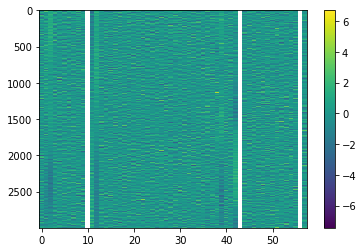

In [65]:
plt.imshow(bloksnorm2[:,0,:],aspect='auto',interpolation='none');
plt.colorbar();

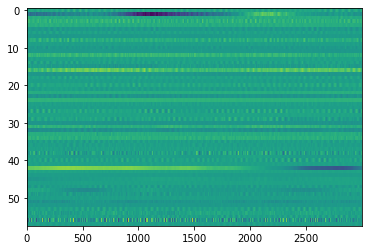

In [275]:
plt.imshow(blok1[:,1,:].T,aspect='auto',interpolation='none')

In [26]:
max_time=float(max([UTCDateTime(quaketime) for quaketime in quakelist['time'].to_numpy()]))
min_time=float(min([UTCDateTime(quaketime) for quaketime in quakelist['time'].to_numpy()]))
max_time,min_time

(1586826402.0, 1352808824.0)

In [27]:
n_samples=2000

rand_times=np.zeros(n_samples)
ii=0
while ii< n_samples:
    t_temp=np.random.uniform(min_time,max_time)
    if not close_to_quake(t_temp):
        rand_times[ii]=t_temp
        ii+=1
        if ii%10==0:
            print(ii)
        

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000


In [28]:
np.save(data_dir+'rand_times2.npy',rand_times)

In [43]:
rt1=np.load(data_dir+'rand_times.npy')

In [44]:
rt1

array([  1.46332678e+09,   1.35966407e+09,   1.46342068e+09, ...,
         1.46752491e+09,   1.43747811e+09,   1.58546297e+09])

In [58]:
file_name=quakelist['eventid'][quake_ind]+'/'+stationlist['station'][station_ind]


In [ ]:
ii=0
for quake_ind in rand_inds:
    t=UTCDateTime(quakelist['time'][quake_ind])
    if not os.path.exists('data/'+quakelist['eventid'][quake_ind]):
        os.mkdir('data/'+quakelist['eventid'][quake_ind])
    for station_ind in range(len(stationlist)):
        if stationlist['starttime'][station_ind]<t:
            try:
                st= client.get_waveforms("NZ",stationlist['station'][station_ind] ,"*", "H??", t-3600, t+3600 ,attach_response=True)
                file_name='data/'+quakelist['eventid'][quake_ind]+'/'+stationlist['station'][station_ind]+'.pkl'#/data/'+quakelist['eventid'][quake_ind]+'/' +stationlist['station'][station_ind]+'.pkl'
                print(file_name)
#                 pkl_file=open(file_name,'wb')
#                 pickle.dump(st,pkl_file)
                with open(file_name,'wb') as f:
                    pickle.dump(st,f)
            except:
                aa={"quakeid":quakelist['eventid'][quake_ind],
                                          "quaketime":quakelist['time'][quake_ind],
                                          "stationid":stationlist['station'][station_ind],
                                          "stationstart":stationlist['starttime'][station_ind]}
                savefail=savefail.append(aa,ignore_index=True)
                print('savefail')
                pass
        else:
            aa={"quakeid":quakelist['eventid'][quake_ind],
                                          "quaketime":quakelist['time'][quake_ind],
                                          "stationid":stationlist['station'][station_ind],
                                          "stationstart":stationlist['starttime'][station_ind]}
            quake_before_station=quake_before_station.append(aa,ignore_index=True)

            print('no')
    ii=ii+1
    print(ii)
    with open('data/quake_before_station.pkl','wb') as f:
        pickle.dump(quake_before_station,f)
    with open('data/savefail.pkl','wb') as f:
        pickle.dump(savefail,f)
        #st = client.get_waveforms("NZ",stationlist['station'][station_ind] ,"*", "H??", t-3600, t+3600 ,attach_response=True)

In [ ]:
st

In [22]:

t = UTCDateTime(data1['time'][0])
st = client.get_waveforms("NZ", "WEL,BHW","*", "H??", t-3600, t+3600 ,attach_response=True)
print(st)

NameError: name 'data1' is not defined

In [ ]:
t,t+

In [ ]:
st.plot()


In [23]:

t = UTCDateTime("2017-04-27T00:00:00.000")
st = client.get_waveforms("NZ", "MAVZ","10", "HHZ", t, t + 800)
st.plot(type="dayplot")

NameError: name 'client' is not defined

In [ ]:
st.data

In [ ]:
st.spectrogram(log=True)


In [ ]:
print(t)

In [ ]:
st

In [ ]:
plt.plot(st[0].data)

In [ ]:
UTCDateTime(-10000)


In [ ]:
UTCDateTime(-1000000)

